Nested sampling analysis of dark dresses at terrestrial detectors. I recommend checking out the [dynesty docs](https://dynesty.readthedocs.io/en/latest/crashcourse.html).

The analysis below requires defining `ptform` (a function mapping numbers from the unit hypercube `[0, 1]^n` to a point `x` in the parameter space to define the prior), `unpack` (a function taking `x` and parsing it into a dark dress) and a likelihood function.

In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
import pickle
from typing import Tuple

import dynesty
from dynesty import plotting as dyplot
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import root_scalar
from tqdm.auto import trange

from pydd.analysis import (
    calculate_SNR,
    calculate_SNR_cut,
    get_match_pads,
    loglikelihood_fft,
)
from pydd.binary import (
    DynamicDress,
    MSUN,
    PC,
    YR,
    get_f_isco,
    get_M_chirp,
    get_f_range,
    get_m_1,
    get_rho_6,
    get_rho_s,
)

Array = jnp.ndarray
GAMMA_S_PBH = jnp.array(9 / 4)
RHO_S_PBH = 1.798e4 * MSUN / PC ** 3

## Set up signal system

In [119]:
# Set detector
detector = "et"

In [120]:
# Set noise and other globals based on detector
if detector == "et":
    from pydd.noise import S_n_et as S_n, f_range_et as f_range_n  # ET

    T_OBS = 1 * YR
    SNR_THRESH = 12.0
    TITLE = "Einstein Telescope"
elif detector == "ce":
    from pydd.noise import S_n_ce as S_n, f_range_ce as f_range_n  # CE

    T_OBS = 1 * YR
    SNR_THRESH = 12.0
    TITLE = "Cosmic Explorer"
elif detector == "aLIGO":
    from pydd.noise import S_n_aLIGO as S_n, f_range_aLIGO as f_range_n  # aLIGO

    T_OBS = 1 * YR
    SNR_THRESH = 12.0
    TITLE = "aLIGO"
elif detector == "LISA":
    from pydd.noise import S_n_LISA as S_n, f_range_LISA as f_range_n  # LISA

    T_OBS = 5 * YR
    SNR_THRESH = 15.0
    TITLE = "LISA"

In [121]:
def get_signal_system() -> Tuple[DynamicDress, Tuple[float, float]]:
    """
    Creates a dark dress with correct SNR for given detector.
    
    Returns:
        The dark dress and frequency range corresponding to an observing time
        of ``T_OBS`` before coalescence.
    """
    M_1 = jnp.array(1 * MSUN)
    M_2 = jnp.array(1e-3 * MSUN)
    M_CHIRP = get_M_chirp(M_1, M_2)
    Q = M_2 / M_1
    GAMMA_S = GAMMA_S_PBH
    RHO_6 = get_rho_6(RHO_S_PBH, M_1, GAMMA_S_PBH)
    TT_C = jnp.array(0.0)
    F_C = get_f_isco(M_1)
    PHI_C = jnp.array(0.0)
    _DD_D = DynamicDress(
        GAMMA_S,
        RHO_6,
        get_M_chirp(M_1, M_2),
        M_2 / M_1,
        PHI_C,
        tT_c=TT_C,
        dL=jnp.array(100e6 * PC),
        f_c=get_f_isco(M_1),
    )

    # Frequency range and grids
    F_RANGE_D = get_f_range(_DD_D, T_OBS)
    FS = jnp.linspace(
        max(F_RANGE_D[0], f_range_n[0]), min(F_RANGE_D[1], f_range_n[1]), 10_000
    )

    # Get dL
    _fn = jax.jit(
        lambda dL: calculate_SNR(
            DynamicDress(
                _DD_D.gamma_s,
                _DD_D.rho_6,
                _DD_D.M_chirp,
                _DD_D.q,
                _DD_D.Phi_c,
                _DD_D.tT_c,
                dL,
                _DD_D.f_c,
            ),
            FS,
            S_n,
        )
    )
    res = root_scalar(
        lambda dL: (_fn(dL) - SNR_THRESH), bracket=(0.1e6 * PC, 100000e6 * PC)
    )
    assert res.converged
    DL = res.root

    # Signal system
    DD_D = DynamicDress(
        _DD_D.gamma_s,
        _DD_D.rho_6,
        _DD_D.M_chirp,
        _DD_D.q,
        _DD_D.Phi_c,
        _DD_D.tT_c,
        DL,
        _DD_D.f_c,
    )

    return DD_D, F_RANGE_D

In [122]:
DD_D, F_RANGE_D = get_signal_system()

# FS = jnp.linspace(*F_RANGE_D, 10_000)  # coarse grid
FS = jnp.linspace(*F_RANGE_D, 30_000)  # finer grid
PAD_LOW, PAD_HIGH = get_match_pads(FS)  # padding for likelihood calculation

## 1D

In 1D we can compute the likelihood at a bunch of random points to see what we expect for parameter errors. Here we look at how well the chirp mass is measured. We parametrize deviations away from the true chirp mass.

Note that `ptform` should be different for different detectors since they will have different measurement accuracy. Depending on what `detector` is set to above, you may need to play with this to get the plot to look reasonable.

In [130]:
def ptform(u: np.ndarray) -> jnp.ndarray:
    """
    Maps [0, 1] to deviations away from ``DD_D.M_chirp / MSUN``.
    """
    assert u.shape == (1,)
    v_m = jnp.array([1e-10])
    return 2 * v_m * (u - 0.5)


def unpack(x: jnp.ndarray) -> DynamicDress:
    """
    Convenience function to unpack parameters into a dark dress.
    """
    dMc_MSUN = x[0]
    Mc = DD_D.M_chirp + dMc_MSUN * MSUN
    m_1 = get_m_1(Mc, DD_D.q)
    rho_s = get_rho_s(DD_D.rho_6, m_1, DD_D.gamma_s)
    rho_6 = get_rho_6(rho_s, m_1, DD_D.gamma_s)
    f_c = get_f_isco(m_1)
    return DynamicDress(
        DD_D.gamma_s, rho_6, Mc, DD_D.q, DD_D.Phi_c, DD_D.tT_c, DD_D.dL, f_c
    )


@jax.jit
def get_ll_fft(x: jnp.ndarray) -> jnp.ndarray:
    """
    Likelihood function
    """
    dd_h = unpack(x)
    return loglikelihood_fft(dd_h, DD_D, FS, PAD_LOW, PAD_HIGH, S_n)

In [131]:
# Sample points and compute likelihood
xs = []
lls = []
for _ in trange(100):
    xs.append(ptform(np.random.rand(1)))
    lls.append(get_ll_fft(xs[-1]))

xs = jnp.array(xs)
lls = jnp.array(lls)

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'Likelihood')

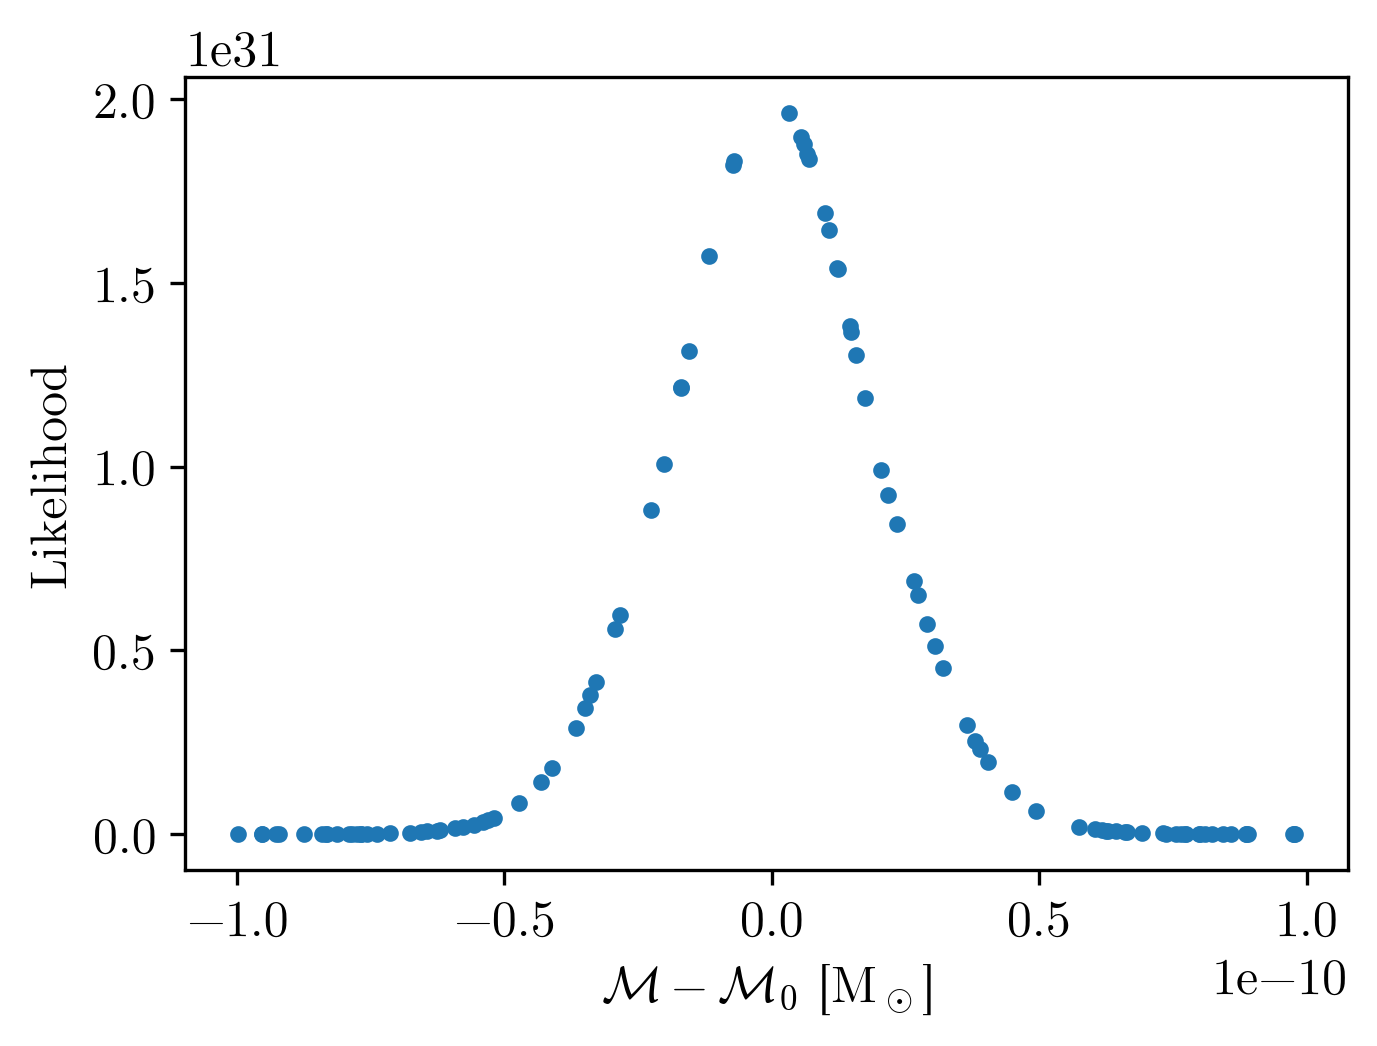

In [137]:
plt.plot(xs, jnp.exp(lls), ".")
plt.xlabel(r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]")
plt.ylabel("Likelihood")
plt.title(detector)

## 2D

In 2D we can also randomly sample points and compute the likelihood. It's clearly tougher than in 1D, though: as you can see, the high-likelihood region is a small, narrow ellipse contained in a large prior region. Here we again parametrize in terms of deviations from the true dark dress parameters. This time we look at the distribution over the chirp mass and spike slope.

Here I've made `ptform` dependent on the detector.

In [77]:
if detector == "et":

    def ptform(u):
        assert u.shape == (2,)
        v_m = 2 * jnp.array([1.5e-10, 2e-5])
        return 2 * v_m * (u - 0.5)


elif detector == "ce":

    def ptform(u):
        assert u.shape == (2,)
        v_m = 10 * jnp.array([1.5e-10, 2e-5])
        return 2 * v_m * (u - 0.5)


elif detector == "aLIGO":

    def ptform(u):
        assert u.shape == (2,)
        v_m = 10 * jnp.array([3e-10, 2e-7])
        return 2 * v_m * (u - 0.5)


def unpack(x):
    dMc_MSUN = x[0]
    dg_s = x[1]
    Mc = DD_D.M_chirp + dMc_MSUN * MSUN
    gamma_s = DD_D.gamma_s + dg_s

    m_1 = get_m_1(Mc, DD_D.q)
    rho_s = get_rho_s(DD_D.rho_6, m_1, gamma_s)
    rho_6 = get_rho_6(rho_s, m_1, gamma_s)
    f_c = get_f_isco(m_1)
    return DynamicDress(gamma_s, rho_6, Mc, DD_D.q, DD_D.Phi_c, DD_D.tT_c, DD_D.dL, f_c)


@jax.jit
def get_ll_fft(x):
    dd_h = unpack(x)
    return loglikelihood_fft(dd_h, DD_D, FS, PAD_LOW, PAD_HIGH, S_n)

In [132]:
# Sample from prior and compute likelihood
xs = []
lls = []
for _ in trange(500):
    xs.append(ptform(np.random.rand(2)))
    lls.append(get_ll_fft(xs[-1]))

xs = jnp.array(xs)
lls = jnp.array(lls)

  0%|          | 0/500 [00:00<?, ?it/s]

AssertionError: 

Text(0.5, 1.0, 'et')

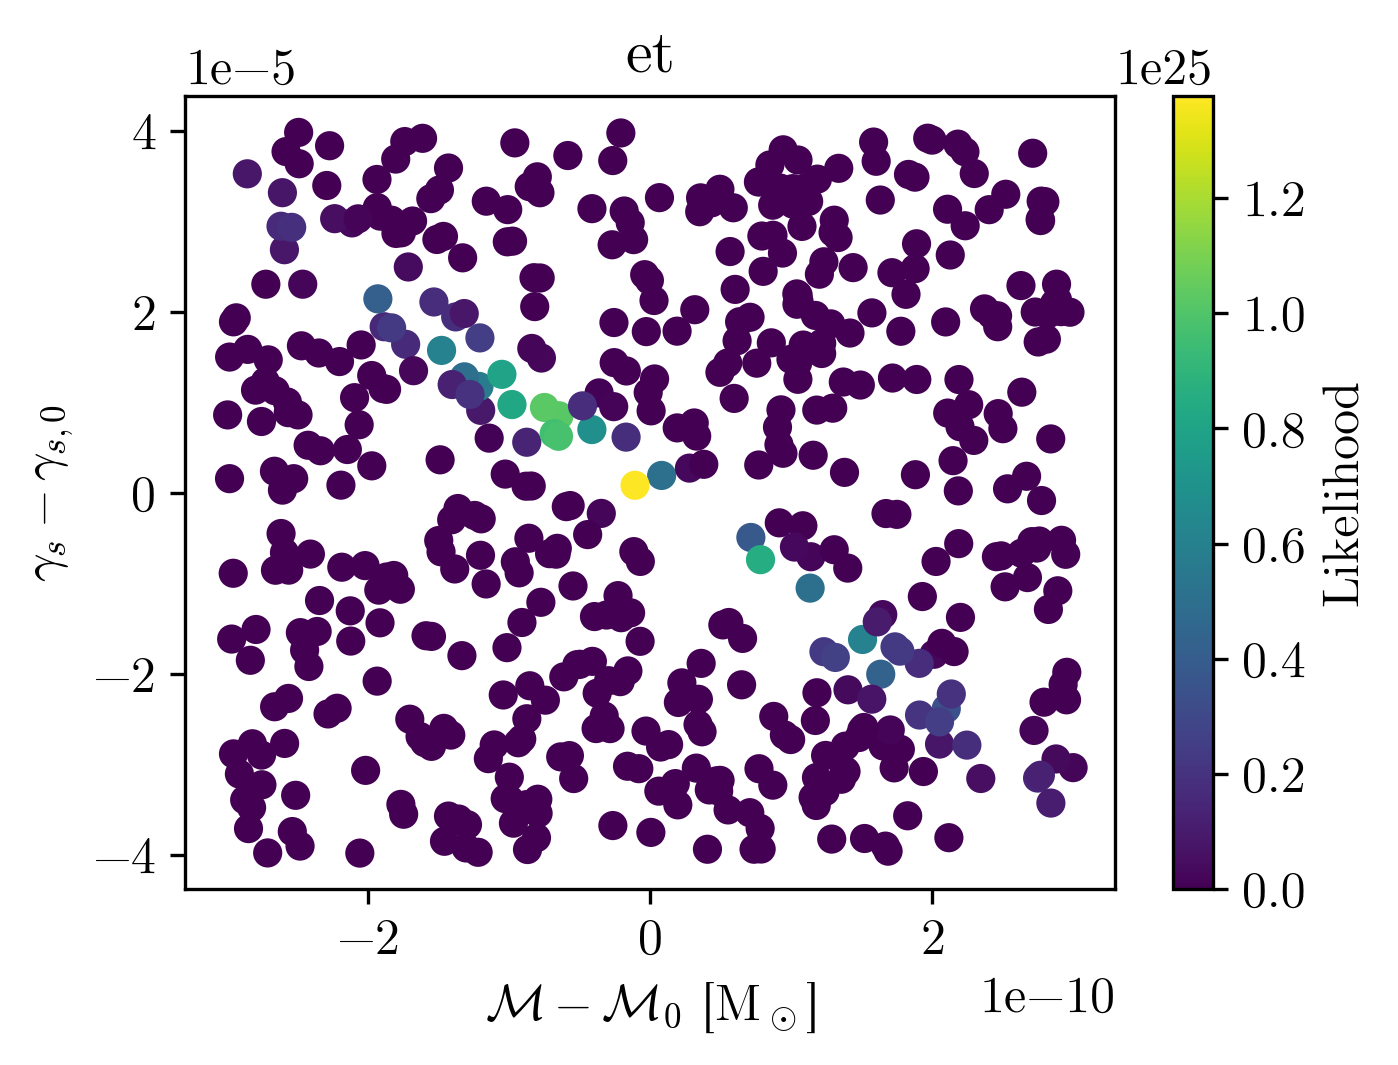

In [79]:
# Plot
plt.scatter(*xs.T, c=jnp.exp(lls - lls.min()))

plt.xlabel(r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]")
plt.ylabel(r"$\gamma_s - \gamma_{s,0}$")
plt.colorbar(label="Likelihood")
plt.title(detector)

## 3D

Figuring out what the posterior looks like with three of the parameters free is much trickier than with only two. Now the high-likelihood region is far smaller than the prior volume. If we just randomly sample from the prior, it's very unlikely we'll generate any points in this region. We'll switch to using nested sampling now. This will take much longer to run than the above examples (hopefully less than 1 hour).

Again, the parameters I'm using here are deviations relative to the true chirp mass, spike slope and spike normalization (in units of $10^{15}\, \mathrm{M}_\odot / \mathrm{pc}^3$).

In [6]:
def ptform(u):
    assert u.shape == (3,)
    v_m = jnp.array([1.5e-6, 3e-5, 2e-3])
    return 2 * v_m * (u - 0.5)


def unpack(x):
    dMc_MSUN = x[0]
    dg_s = x[1]
    dr_6_15_MSUN_PC3 = x[2]
    Mc = DD_D.M_chirp + dMc_MSUN * MSUN
    gamma_s = DD_D.gamma_s + dg_s
    rho_6 = DD_D.rho_6 + dr_6_15_MSUN_PC3 * 1e15 * MSUN / PC ** 3

    m_1 = get_m_1(Mc, DD_D.q)
    f_c = get_f_isco(m_1)
    return DynamicDress(gamma_s, rho_6, Mc, DD_D.q, DD_D.Phi_c, DD_D.tT_c, DD_D.dL, f_c)


@jax.jit
def get_ll_fft(x):
    dd_h = unpack(x)
    return loglikelihood_fft(dd_h, DD_D, FS, PAD_LOW, PAD_HIGH, S_n)

In [124]:
# Use 500 - 2000 live points. You need a lot, otherwise you may miss the
# high-likelihood region!
sampler = dynesty.NestedSampler(get_ll_fft, ptform, 3, nlive=500)
sampler.run_nested()
results = sampler.results

9340it [38:00,  4.10it/s, +500 | bound: 213 | nc: 1 | ncall: 195834 | eff(%):  5.025 | loglstar:   -inf < 72.048 <    inf | logz: 54.125 +/-  0.267 | dlogz:  0.001 >  0.509]


In [127]:
# # Uncomment to save nested sampling results
# with open(f"ns/earth-based-ns-3d.pkl", "wb") as output:
#     pickle.dump(results, output, pickle.HIGHEST_PROTOCOL)

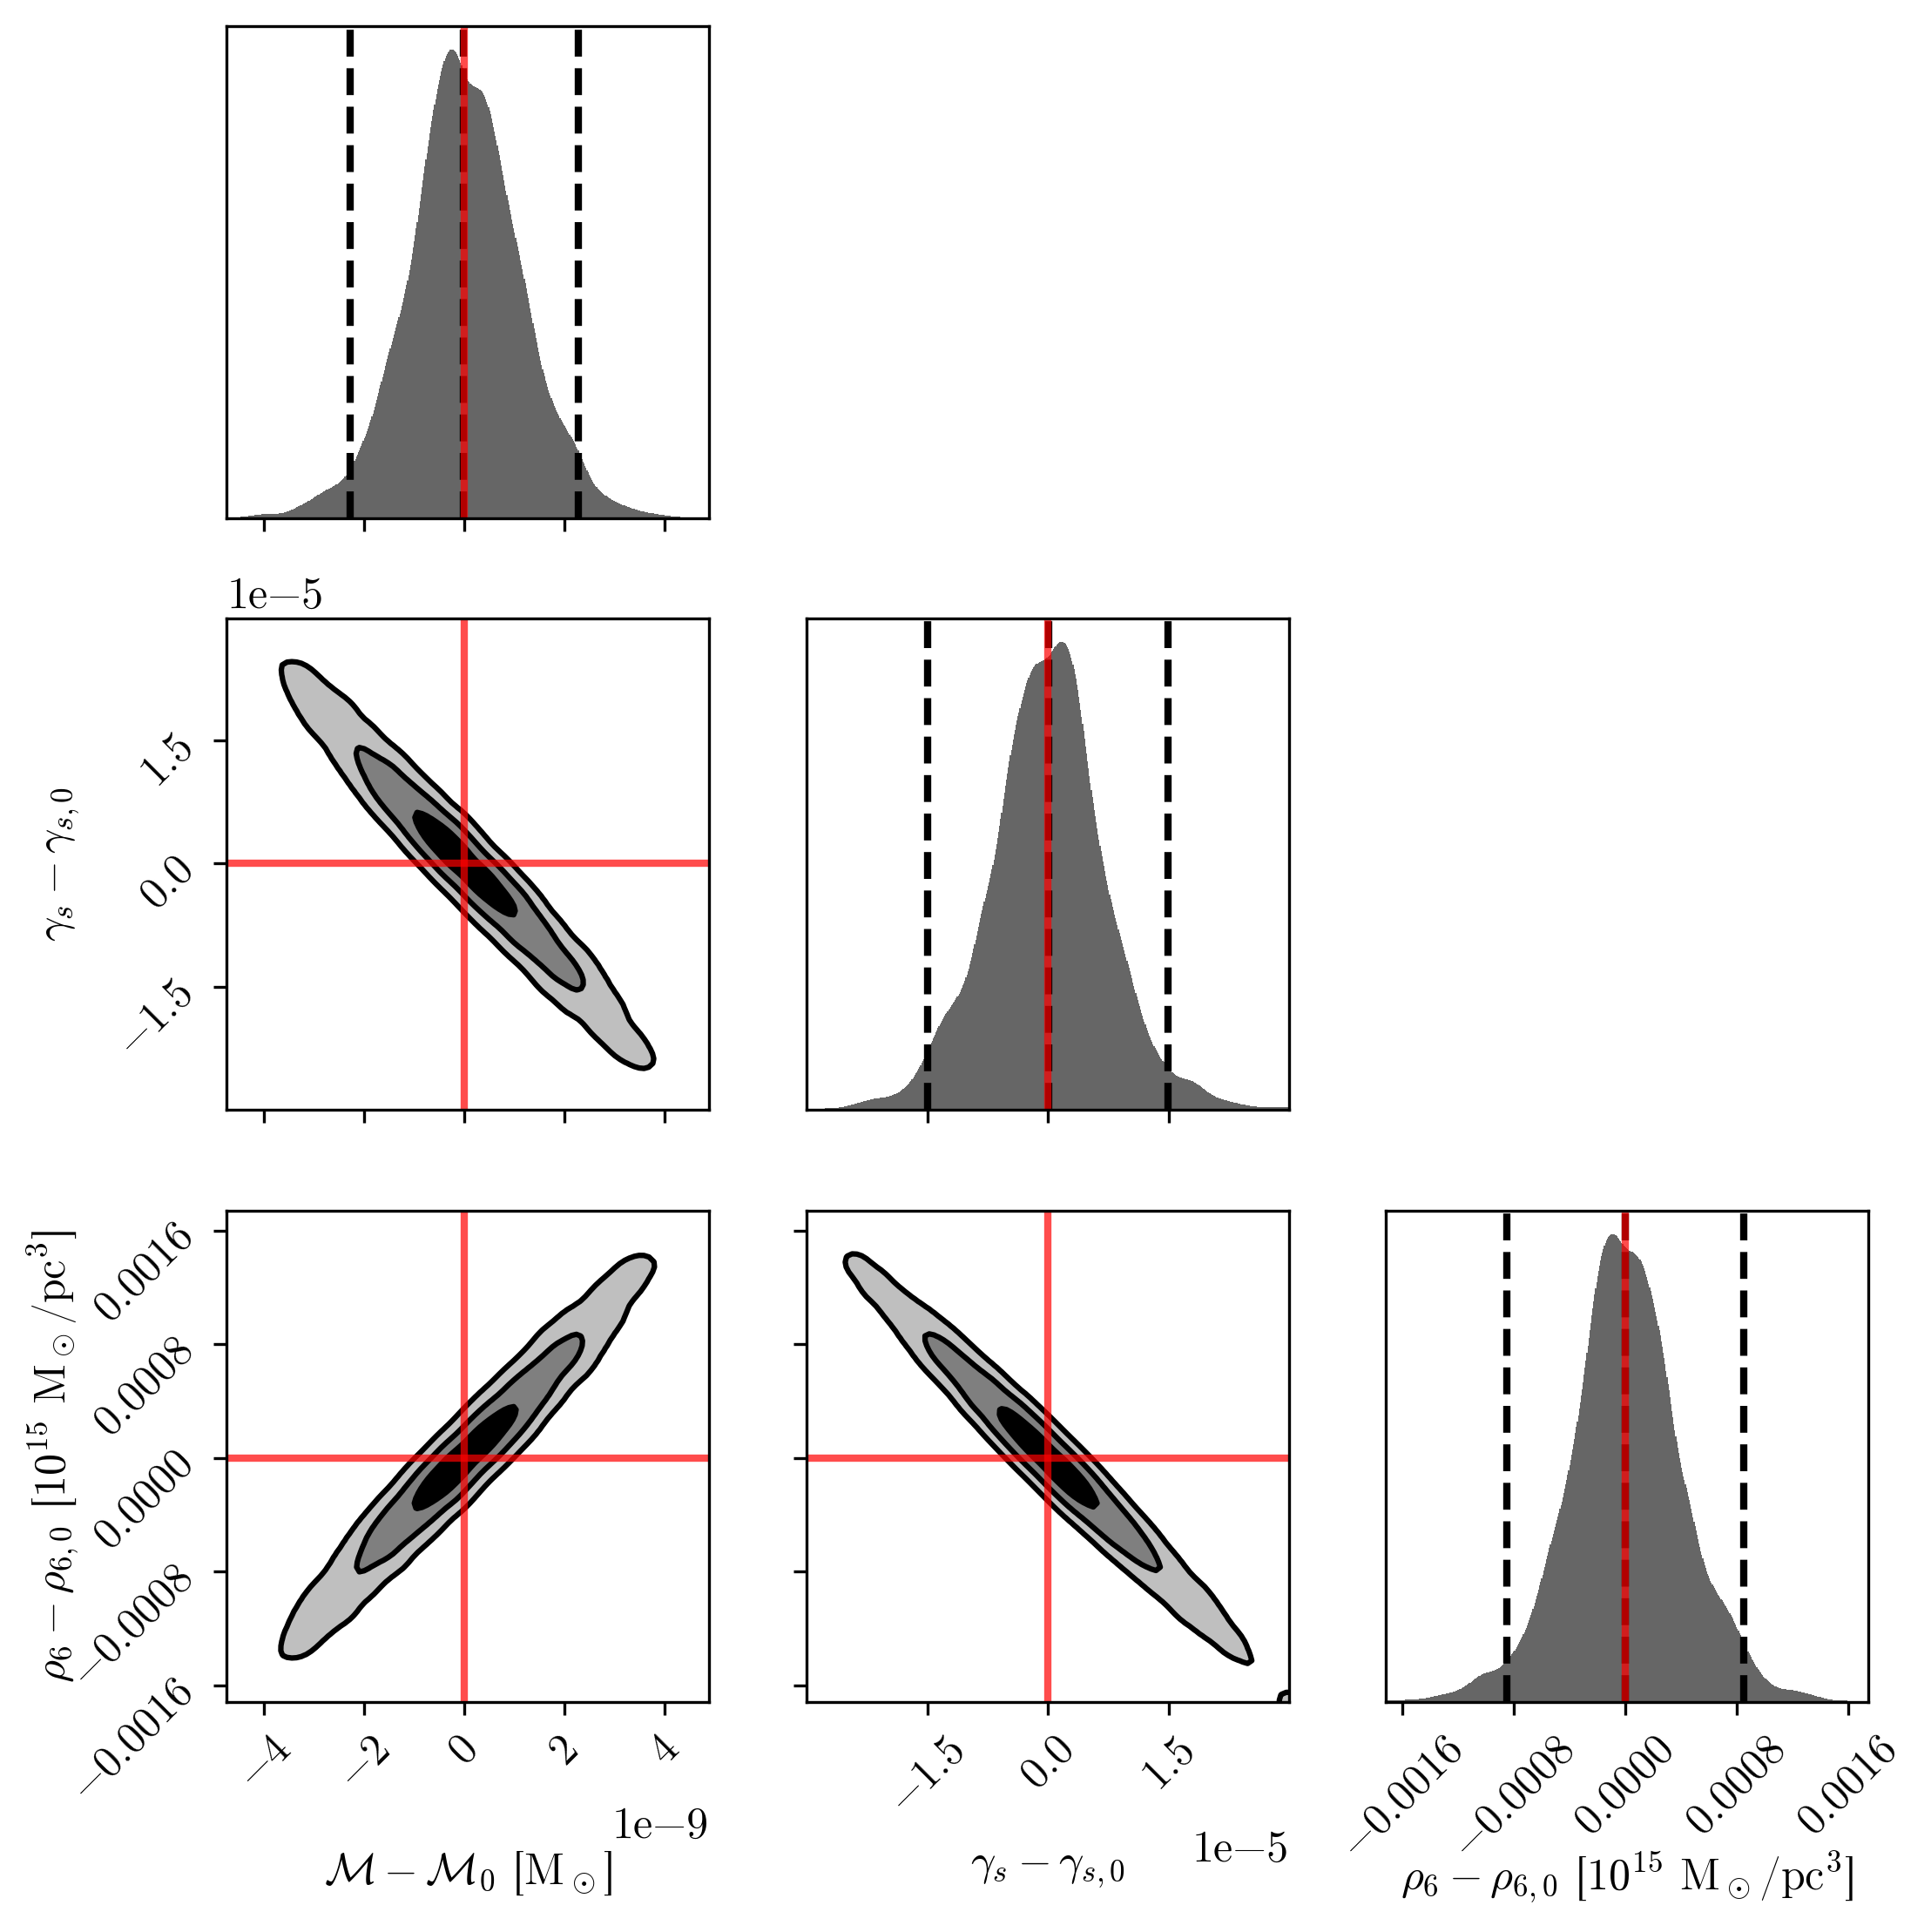

In [130]:
# Plot
labels = (
    r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]",
    r"$\gamma_s - \gamma_{s,0}$",
    r"$\rho_6 - \rho_{6,0}$ [$10^{15}$ M$_\odot$/pc$^3$]",
)
# 
quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]
fig, axes = dyplot.cornerplot(
    results, labels=labels, quantiles_2d=quantiles_2d, truths=(0, 0, 0)
)
fig.tight_layout()

Random sampling. Very inefficient in >2D.

In [5]:
from mpl_toolkits import mplot3d

In [107]:
xs = []
lls = []
for _ in trange(100_000):
    xs.append(ptform(np.random.rand(3)))
    lls.append(get_ll_fft(xs[-1]))

xs = jnp.array(xs)
lls = jnp.array(lls)
ls = jnp.exp(lls)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [108]:
def get_marginal_1d(xs, ls, dim):
    edges = np.histogram(xs[:, dim])[1]

    n = len(edges) - 1
    vals = np.zeros((n,))
    ns = np.zeros((n,))
    for i in range(n):
        idxs = (xs[:, dim] >= edges[i]) & (xs[:, dim] <= edges[i + 1])
        vals[i] = ls[idxs].sum()
        ns[i] = idxs.sum()

    return (
        jnp.array(0.5 * (edges[1:] + edges[:-1])),
        jnp.array(vals) / vals.sum(),
        jnp.array(ns),
    )


def get_marginal_2d(xs, ls, x_dim, y_dim):
    xedges, yedges = np.histogram2d(xs[:, x_dim], xs[:, y_dim])[1:]

    nx = len(xedges) - 1
    ny = len(yedges) - 1
    vals = np.zeros((nx, ny))
    ns = np.zeros((nx, ny))
    for i in range(nx):
        for j in range(ny):
            idxs = (
                (xs[:, x_dim] >= xedges[i])
                & (xs[:, x_dim] <= xedges[i + 1])
                & (xs[:, y_dim] >= yedges[j])
                & (xs[:, y_dim] <= yedges[j + 1])
            )
            vals[i, j] = ls[idxs].sum()
            ns[i, j] = idxs.sum()

    return (
        jnp.array(0.5 * (xedges[1:] + xedges[:-1])),
        jnp.array(0.5 * (yedges[1:] + yedges[:-1])),
        jnp.array(vals) / vals.sum(),
        jnp.array(ns),
    )


def plot_marginals(xs, ls, labels, vmax=None):
    n_dims = xs.shape[1]
    fig, axes = plt.subplots(n_dims, n_dims, figsize=(3 * n_dims, 3 * n_dims))
    for i in range(n_dims):
        for j in range(n_dims):
            if i == j:
                axes[i, j].plot(get_marginal_1d(xs, ls, i)[1])
            elif i > j:
                axes[i, j].imshow(get_marginal_2d(xs, ls, i, j)[2], vmax=vmax)
            else:
                axes[i, j].axis("off")

    for i, ax in enumerate(axes[-1, :]):
        ax.set_xlabel(labels[i])

    for i, ax in enumerate(axes[:, 0]):
        ax.set_ylabel(labels[i])

    fig.tight_layout()
    return fig, axes

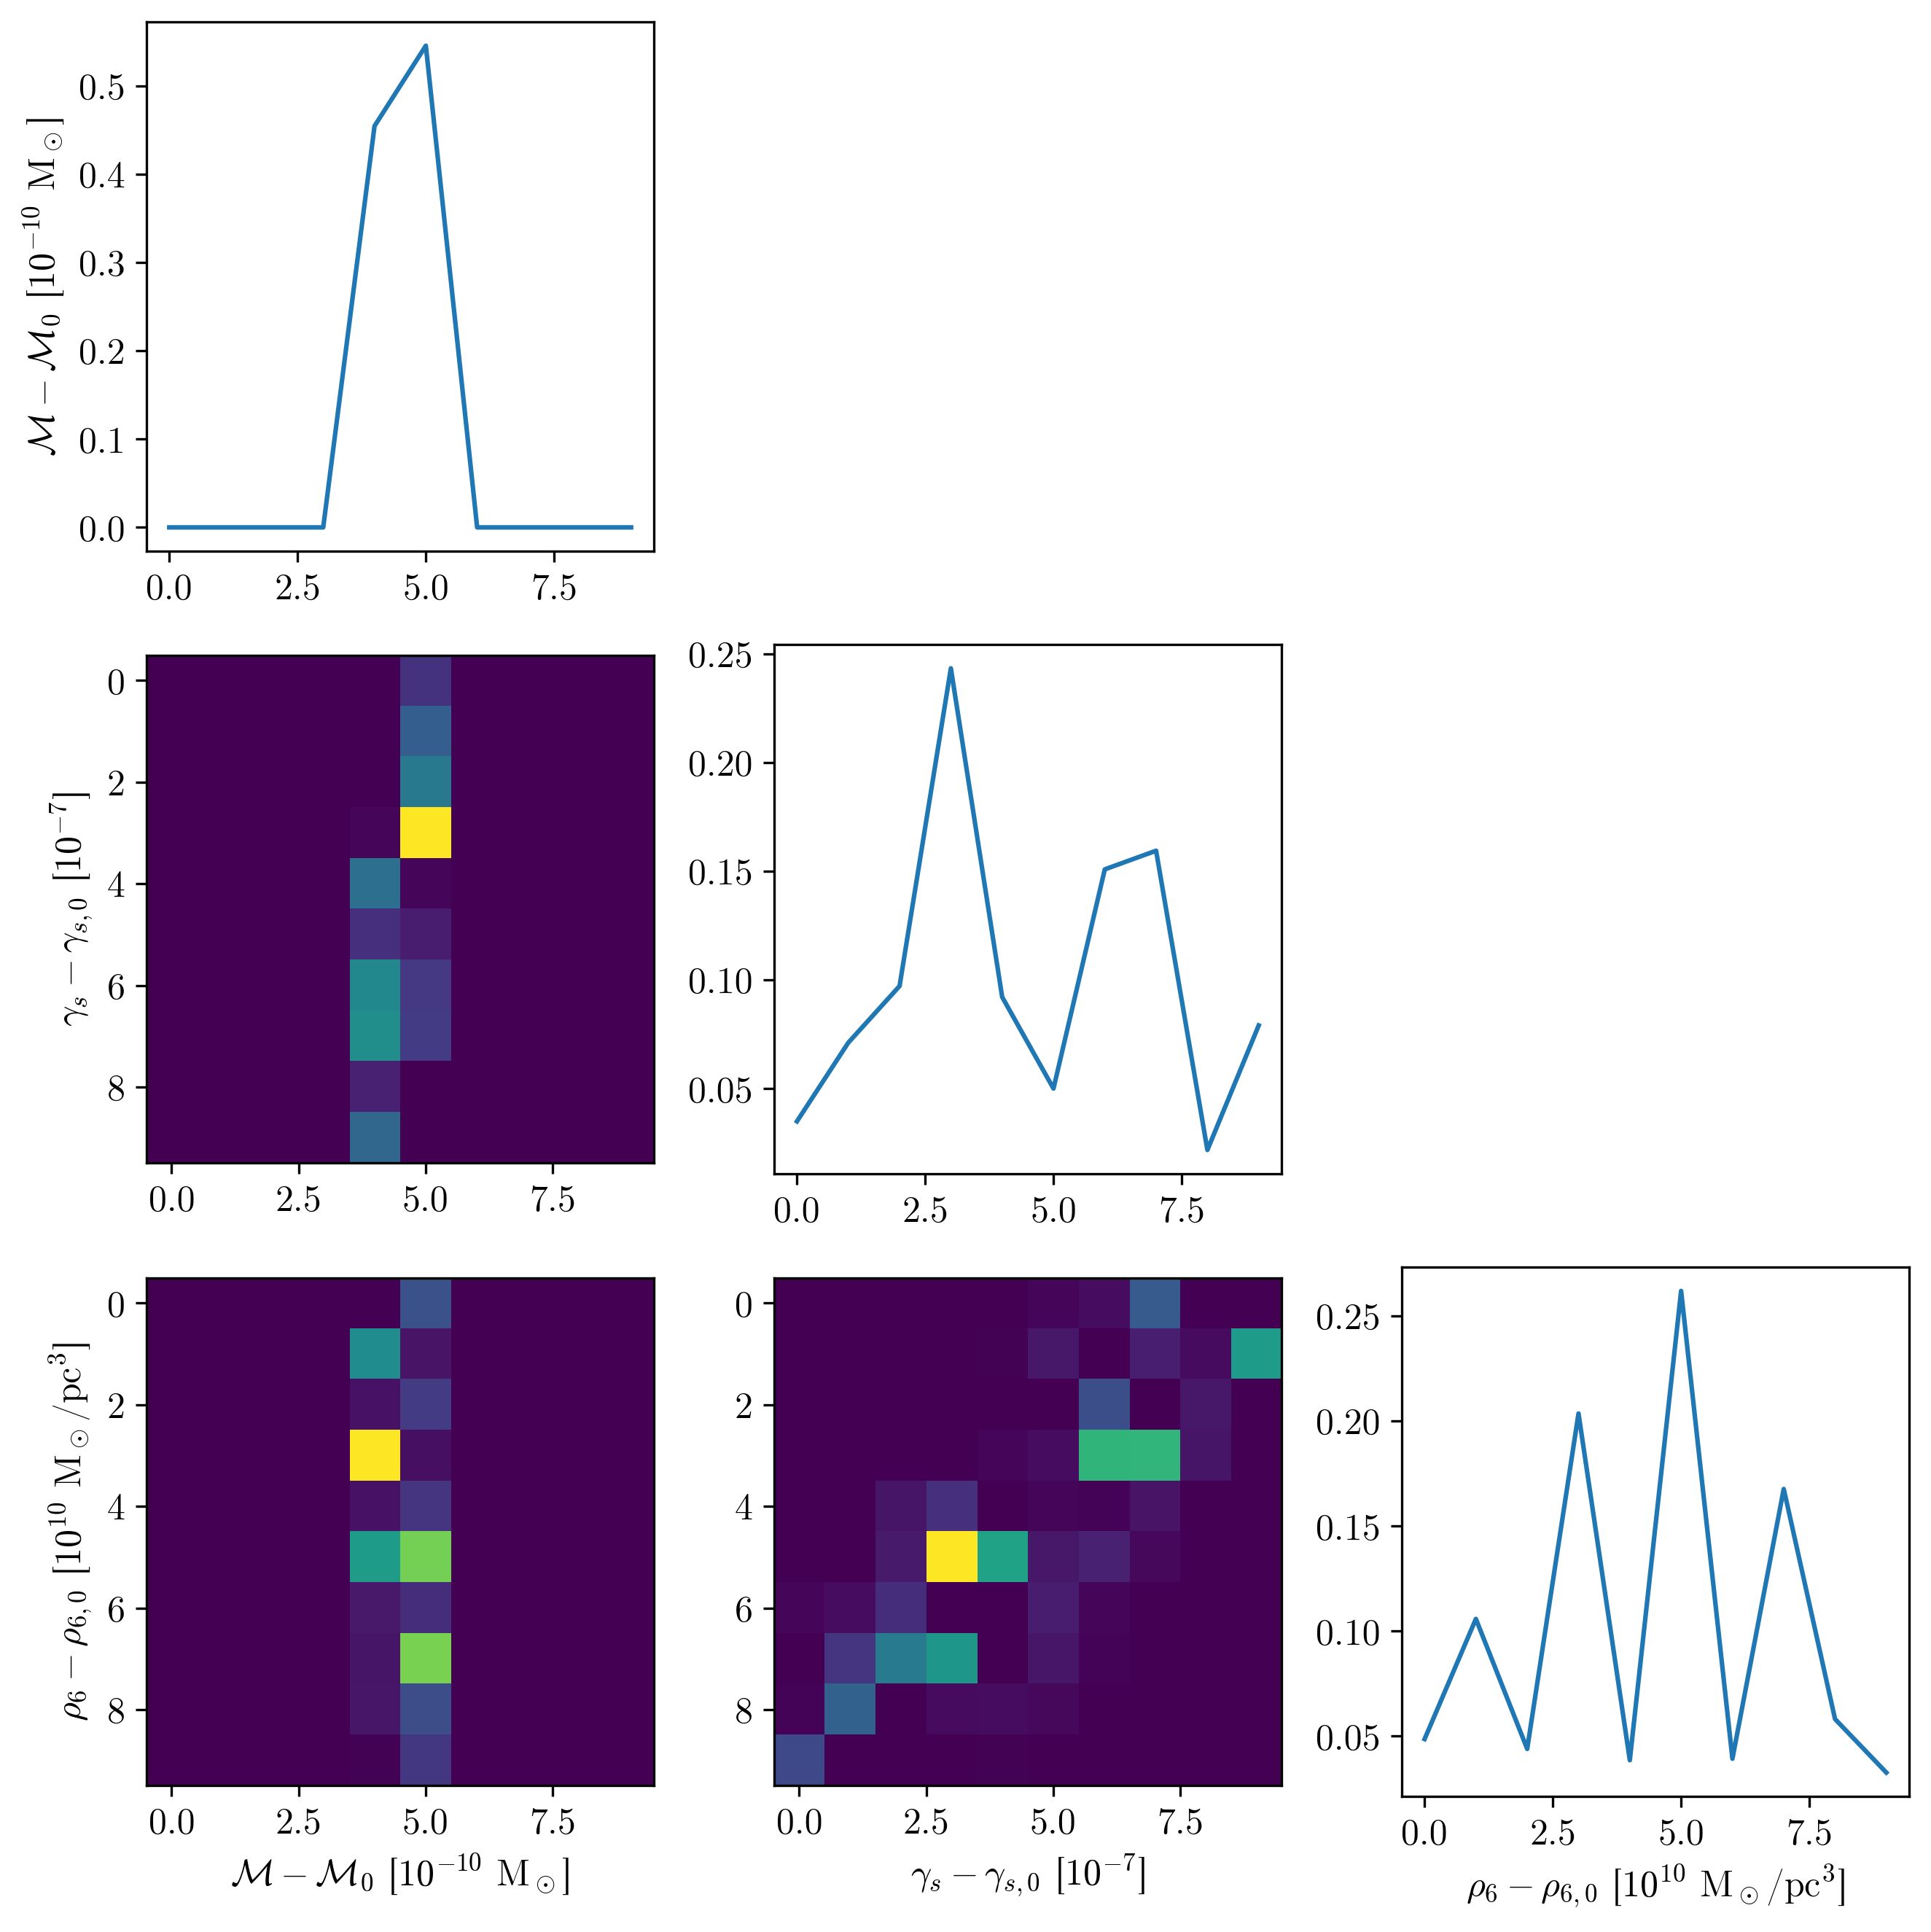

In [109]:
plot_marginals(xs, ls, labels, vmax=None)

## 4D

This is the full analysis. Each run takes 30 min - 2 hr on my laptop.

In [128]:
if detector == "et":  # done

    def ptform(u):
        assert u.shape == (4,)
        central = jnp.array(
            [
                DD_D.gamma_s,
                DD_D.rho_6 / (1e16 * MSUN / PC ** 3),
                DD_D.M_chirp / MSUN,
                jnp.log10(DD_D.q),
            ]
        )
        delta = jnp.array([6e-2, 1e-3, 4.8e-7, 5e-1]) / 5
        v_low = central - delta * jnp.array([3, 2, 1, 3.])
        v_high = central + delta * jnp.array([3, 3, 1, 5.])
        return v_low + (v_high - v_low) * u


elif detector == "ce":  # done

    def ptform(u):
        assert u.shape == (4,)
        central = jnp.array(
            [
                DD_D.gamma_s,
                DD_D.rho_6 / (1e16 * MSUN / PC ** 3),
                DD_D.M_chirp / MSUN,
                jnp.log10(DD_D.q),
            ]
        )
        delta = jnp.array([6e-2, 1e-3, 4.8e-7, 5e-1])
        v_low = central - delta * jnp.array([3, 2, 1, 3.])
        v_high = central + delta * jnp.array([3, 3, 1, 1.])
        return v_low + (v_high - v_low) * u


elif detector == "aLIGO":  # not started

    def ptform(u):
        assert u.shape == (4,)
        central = jnp.array(
            [
                DD_D.gamma_s,
                DD_D.rho_6 / (1e16 * MSUN / PC ** 3),
                DD_D.M_chirp / MSUN,
                jnp.log10(DD_D.q),
            ]
        )
        delta = jnp.array([1.2e-4, 5e-4, 1.6e-8, 8e-4])
        v_low = central - 20 * jnp.array([4, 3, 6, 4]) * delta
        v_high = central + 20 * jnp.array([4, 3, 6, 4]) * delta
        return v_low + (v_high - v_low) * u


def unpack(x):
    gamma_s, rho_6T, Mc_MSUN, log10_q = x
    rho_6 = rho_6T * 1e16 * MSUN / PC ** 3
    M_chirp = Mc_MSUN * MSUN
    q = 10 ** log10_q

    m_1 = get_m_1(M_chirp, q)
    f_c = get_f_isco(m_1)
    return DynamicDress(gamma_s, rho_6, M_chirp, q, DD_D.Phi_c, DD_D.tT_c, DD_D.dL, f_c)


@jax.jit
def get_ll_fft(x):
    dd_h = unpack(x)
    return loglikelihood_fft(dd_h, DD_D, FS, PAD_LOW, PAD_HIGH, S_n)

In [129]:
sampler = dynesty.NestedSampler(get_ll_fft, ptform, 4, nlive=2000)
sampler.run_nested()
# sampler = dynesty.DynamicNestedSampler(get_ll_fft, ptform, 4, nlive=2000)
# sampler.run_nested(nlive_init=500, nlive_batch=100)
results = sampler.results

44596it [1:25:09,  8.73it/s, +2000 | bound: 48 | nc: 1 | ncall: 213801 | eff(%): 21.794 | loglstar:   -inf < 626.840 <    inf | logz: 603.677 +/-  0.180 | dlogz:  0.001 >  2.009]


In [131]:
with open(f"ns/ns-{detector}-4d.pkl", "wb") as output:
    pickle.dump(results, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open(f"ns/ns-{detector}-4d.pkl", "rb") as infile:
#     results = pickle.load(infile)

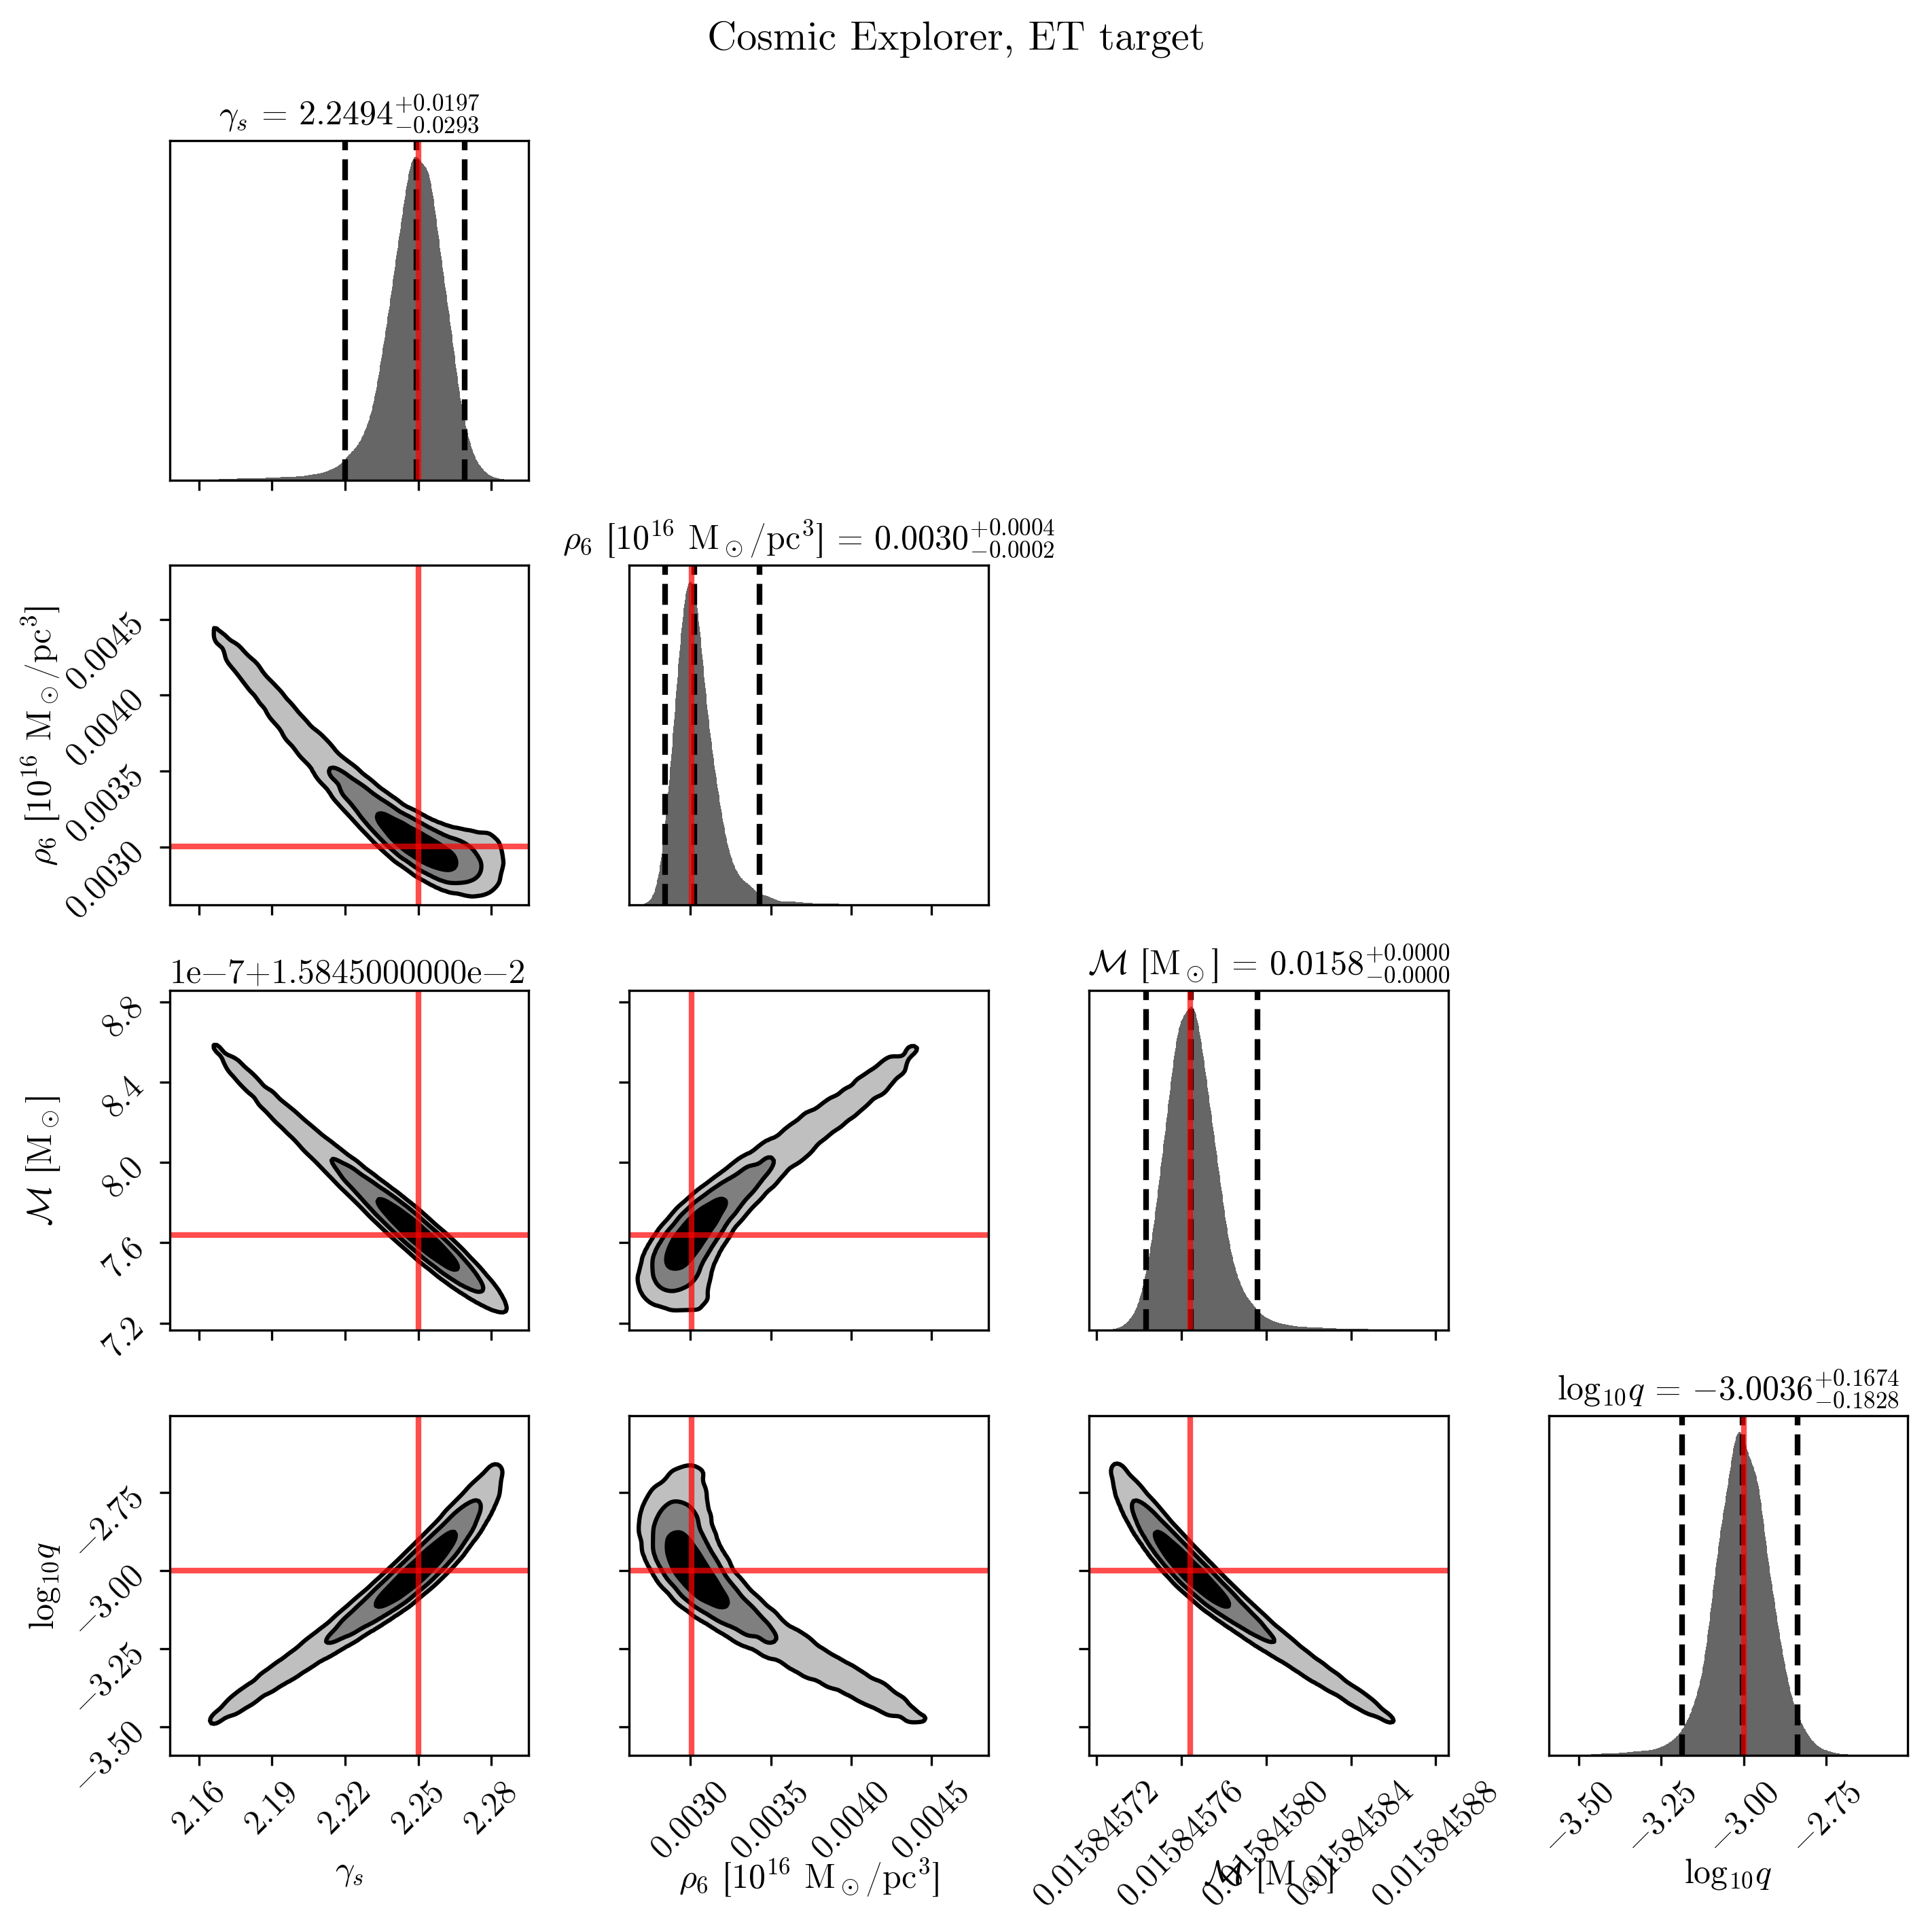

In [133]:
labels = (
    r"$\gamma_s$",
    r"$\rho_6$ [$10^{16}$ M$_\odot$/pc$^3$]",
    r"$\mathcal{M}$ [M$_\odot$]",
    r"$\log_{10} q$",
)
# quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]
quantiles_2d = [0.6827, 0.9545, 0.9973]  # more typical for Bayesian analyses
truths = (
    DD_D.gamma_s,
    DD_D.rho_6 / (1e16 * MSUN / PC ** 3),
    DD_D.M_chirp / MSUN,
    jnp.log10(DD_D.q),
)
fig, axes = dyplot.cornerplot(
    results,
    labels=labels,
    quantiles_2d=quantiles_2d,
    smooth=0.015,
    truths=truths,
    show_titles=True,
    title_kwargs={"fontsize": 12},
    title_fmt=".4f",
)
fig.suptitle(TITLE)
fig.tight_layout()
fig.savefig(f"figures/ns-{detector}.pdf")

## Load and plot results

In [137]:
labels = (
    r"$\gamma_s$",
    r"$\rho_6$ [$10^{16}$ M$_\odot$/pc$^3$]",
    r"$\mathcal{M}$ [M$_\odot$]",
    r"$\log_{10} q$",
)
# quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]
quantiles_2d = [0.6827, 0.9545, 0.9973]  # more typical for Bayesian analyses
truths = (
    DD_D.gamma_s,
    DD_D.rho_6 / (1e16 * MSUN / PC ** 3),
    DD_D.M_chirp / MSUN,
    jnp.log10(DD_D.q),
)

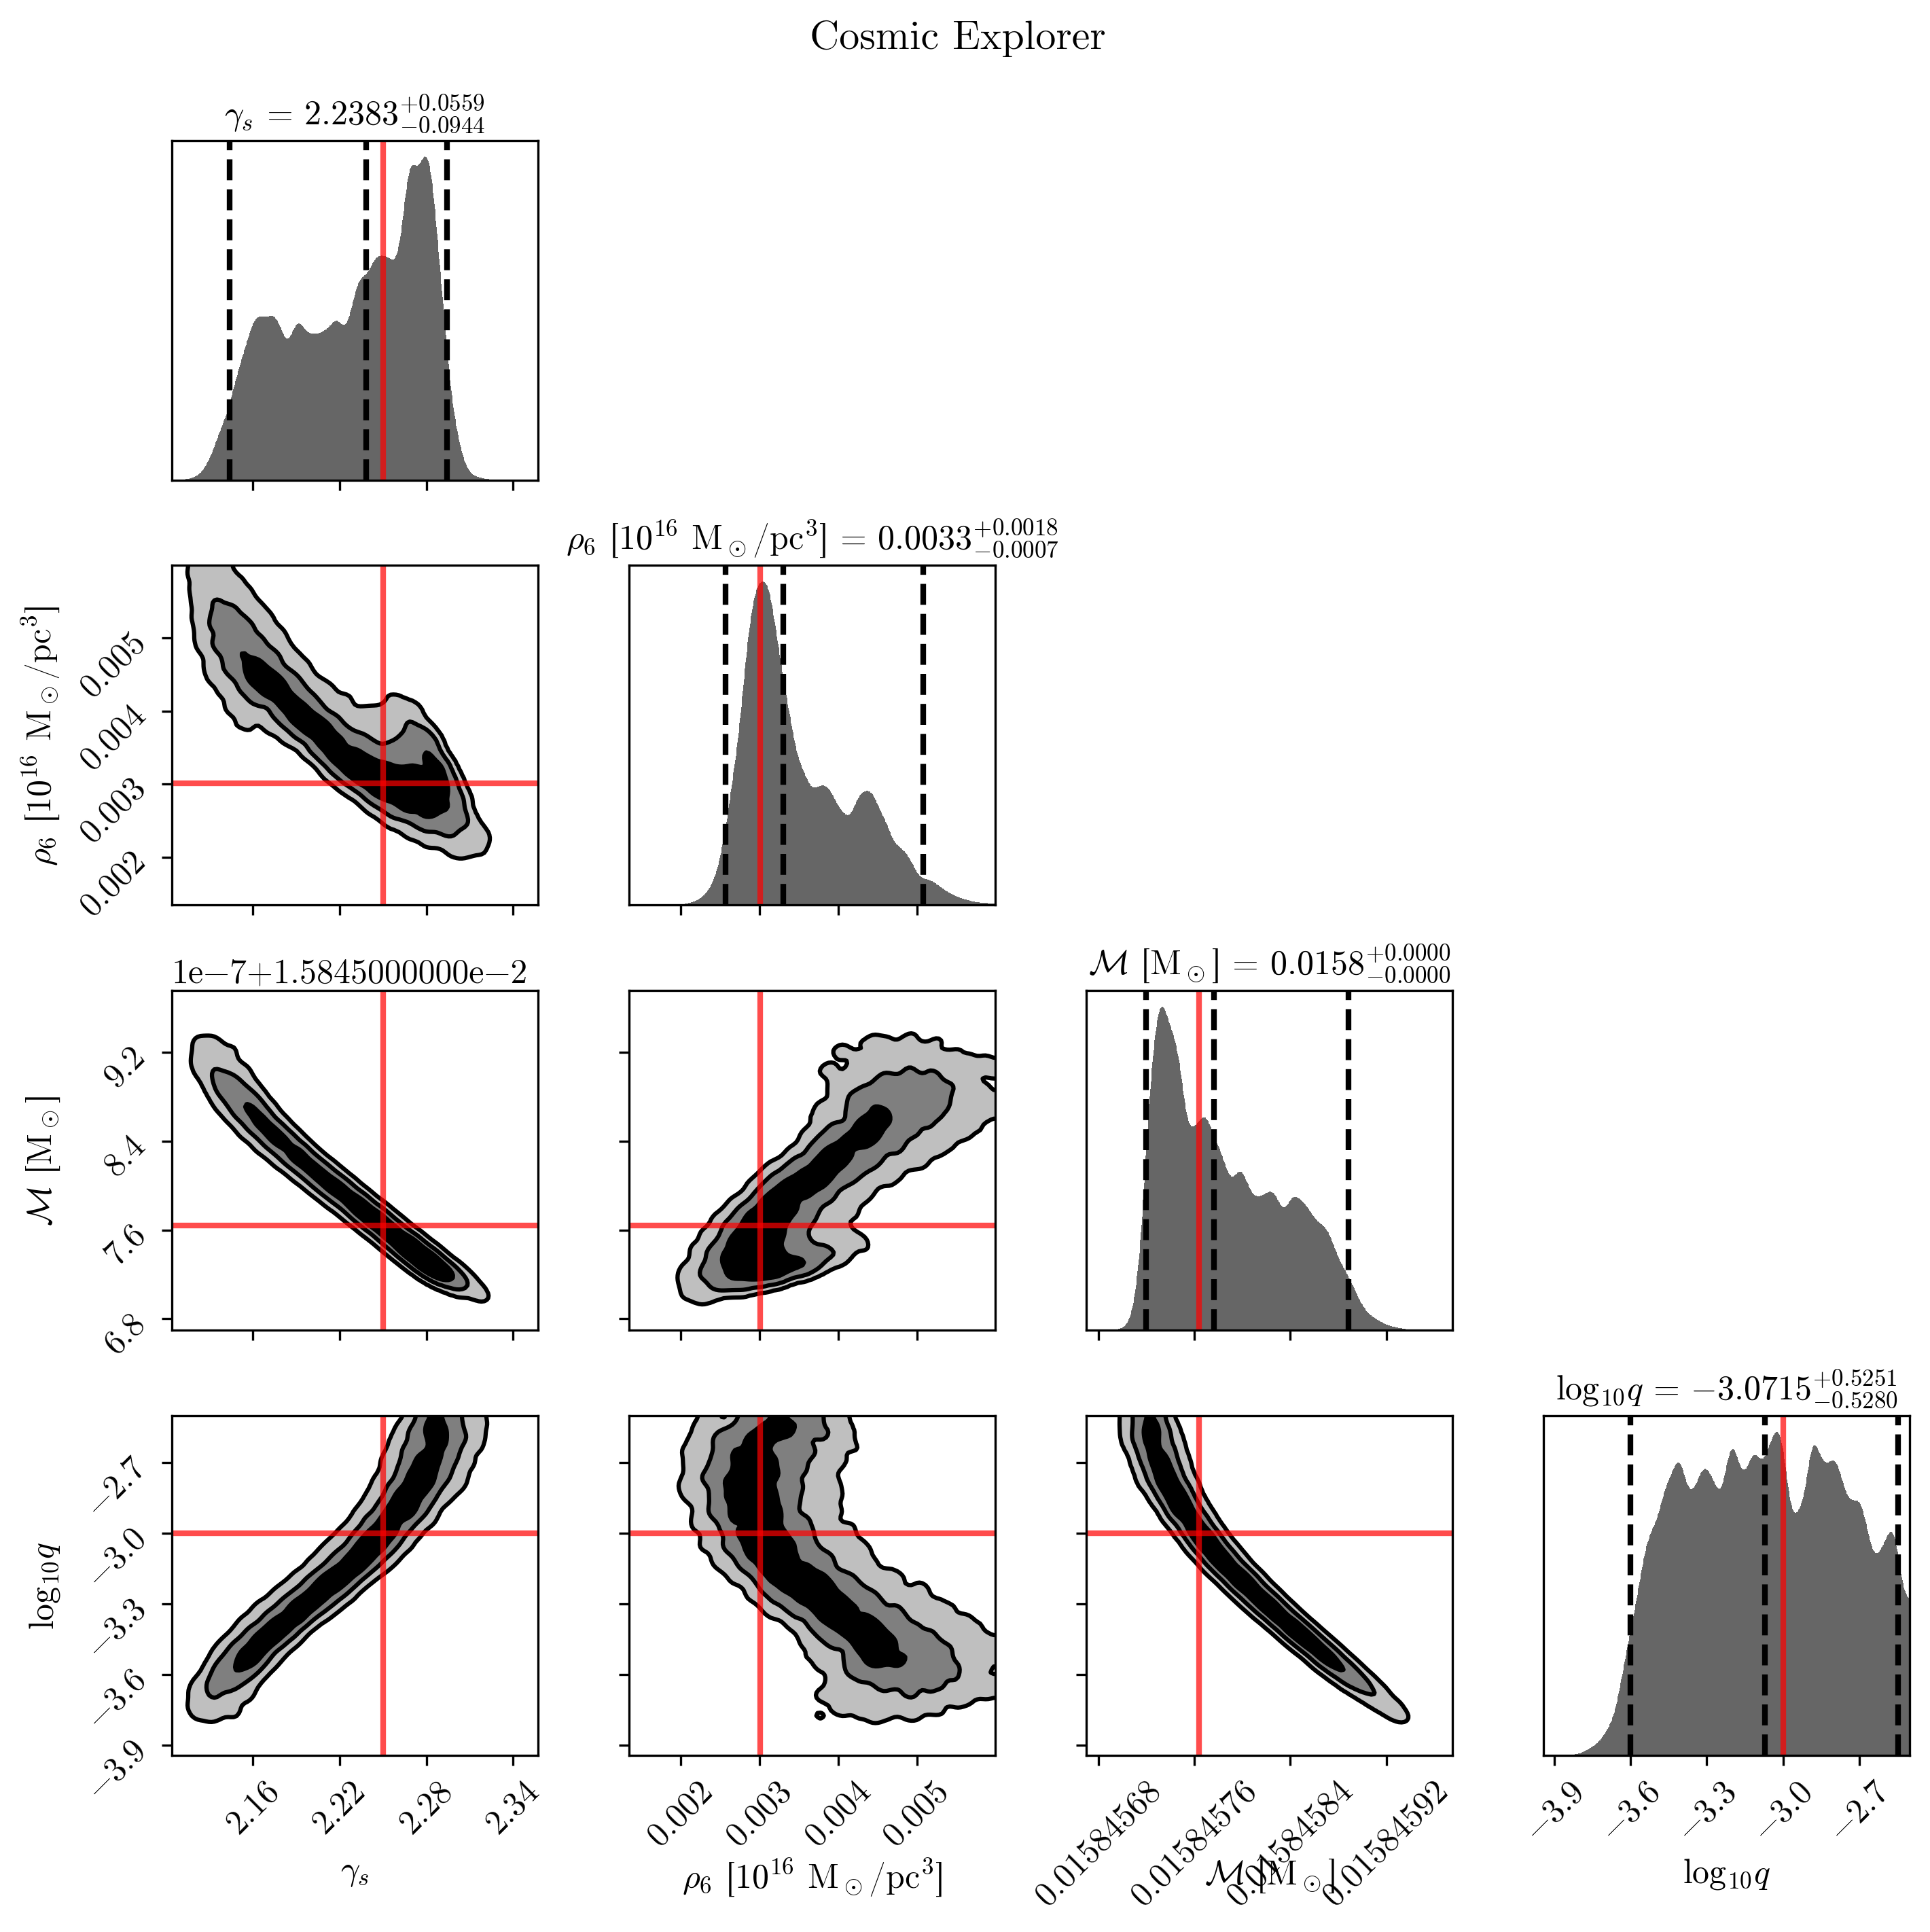

In [138]:
with open(f"ns/ns-ce-4d.pkl", "rb") as infile:
    results = pickle.load(infile)

fig, axes = dyplot.cornerplot(
    results,
    labels=labels,
    quantiles_2d=quantiles_2d,
    smooth=0.015,
    truths=truths,
    show_titles=True,
    title_kwargs={"fontsize": 12},
    title_fmt=".4f",
)
fig.suptitle("Cosmic Explorer")
fig.tight_layout()
fig.savefig(f"figures/ns-ce.pdf")

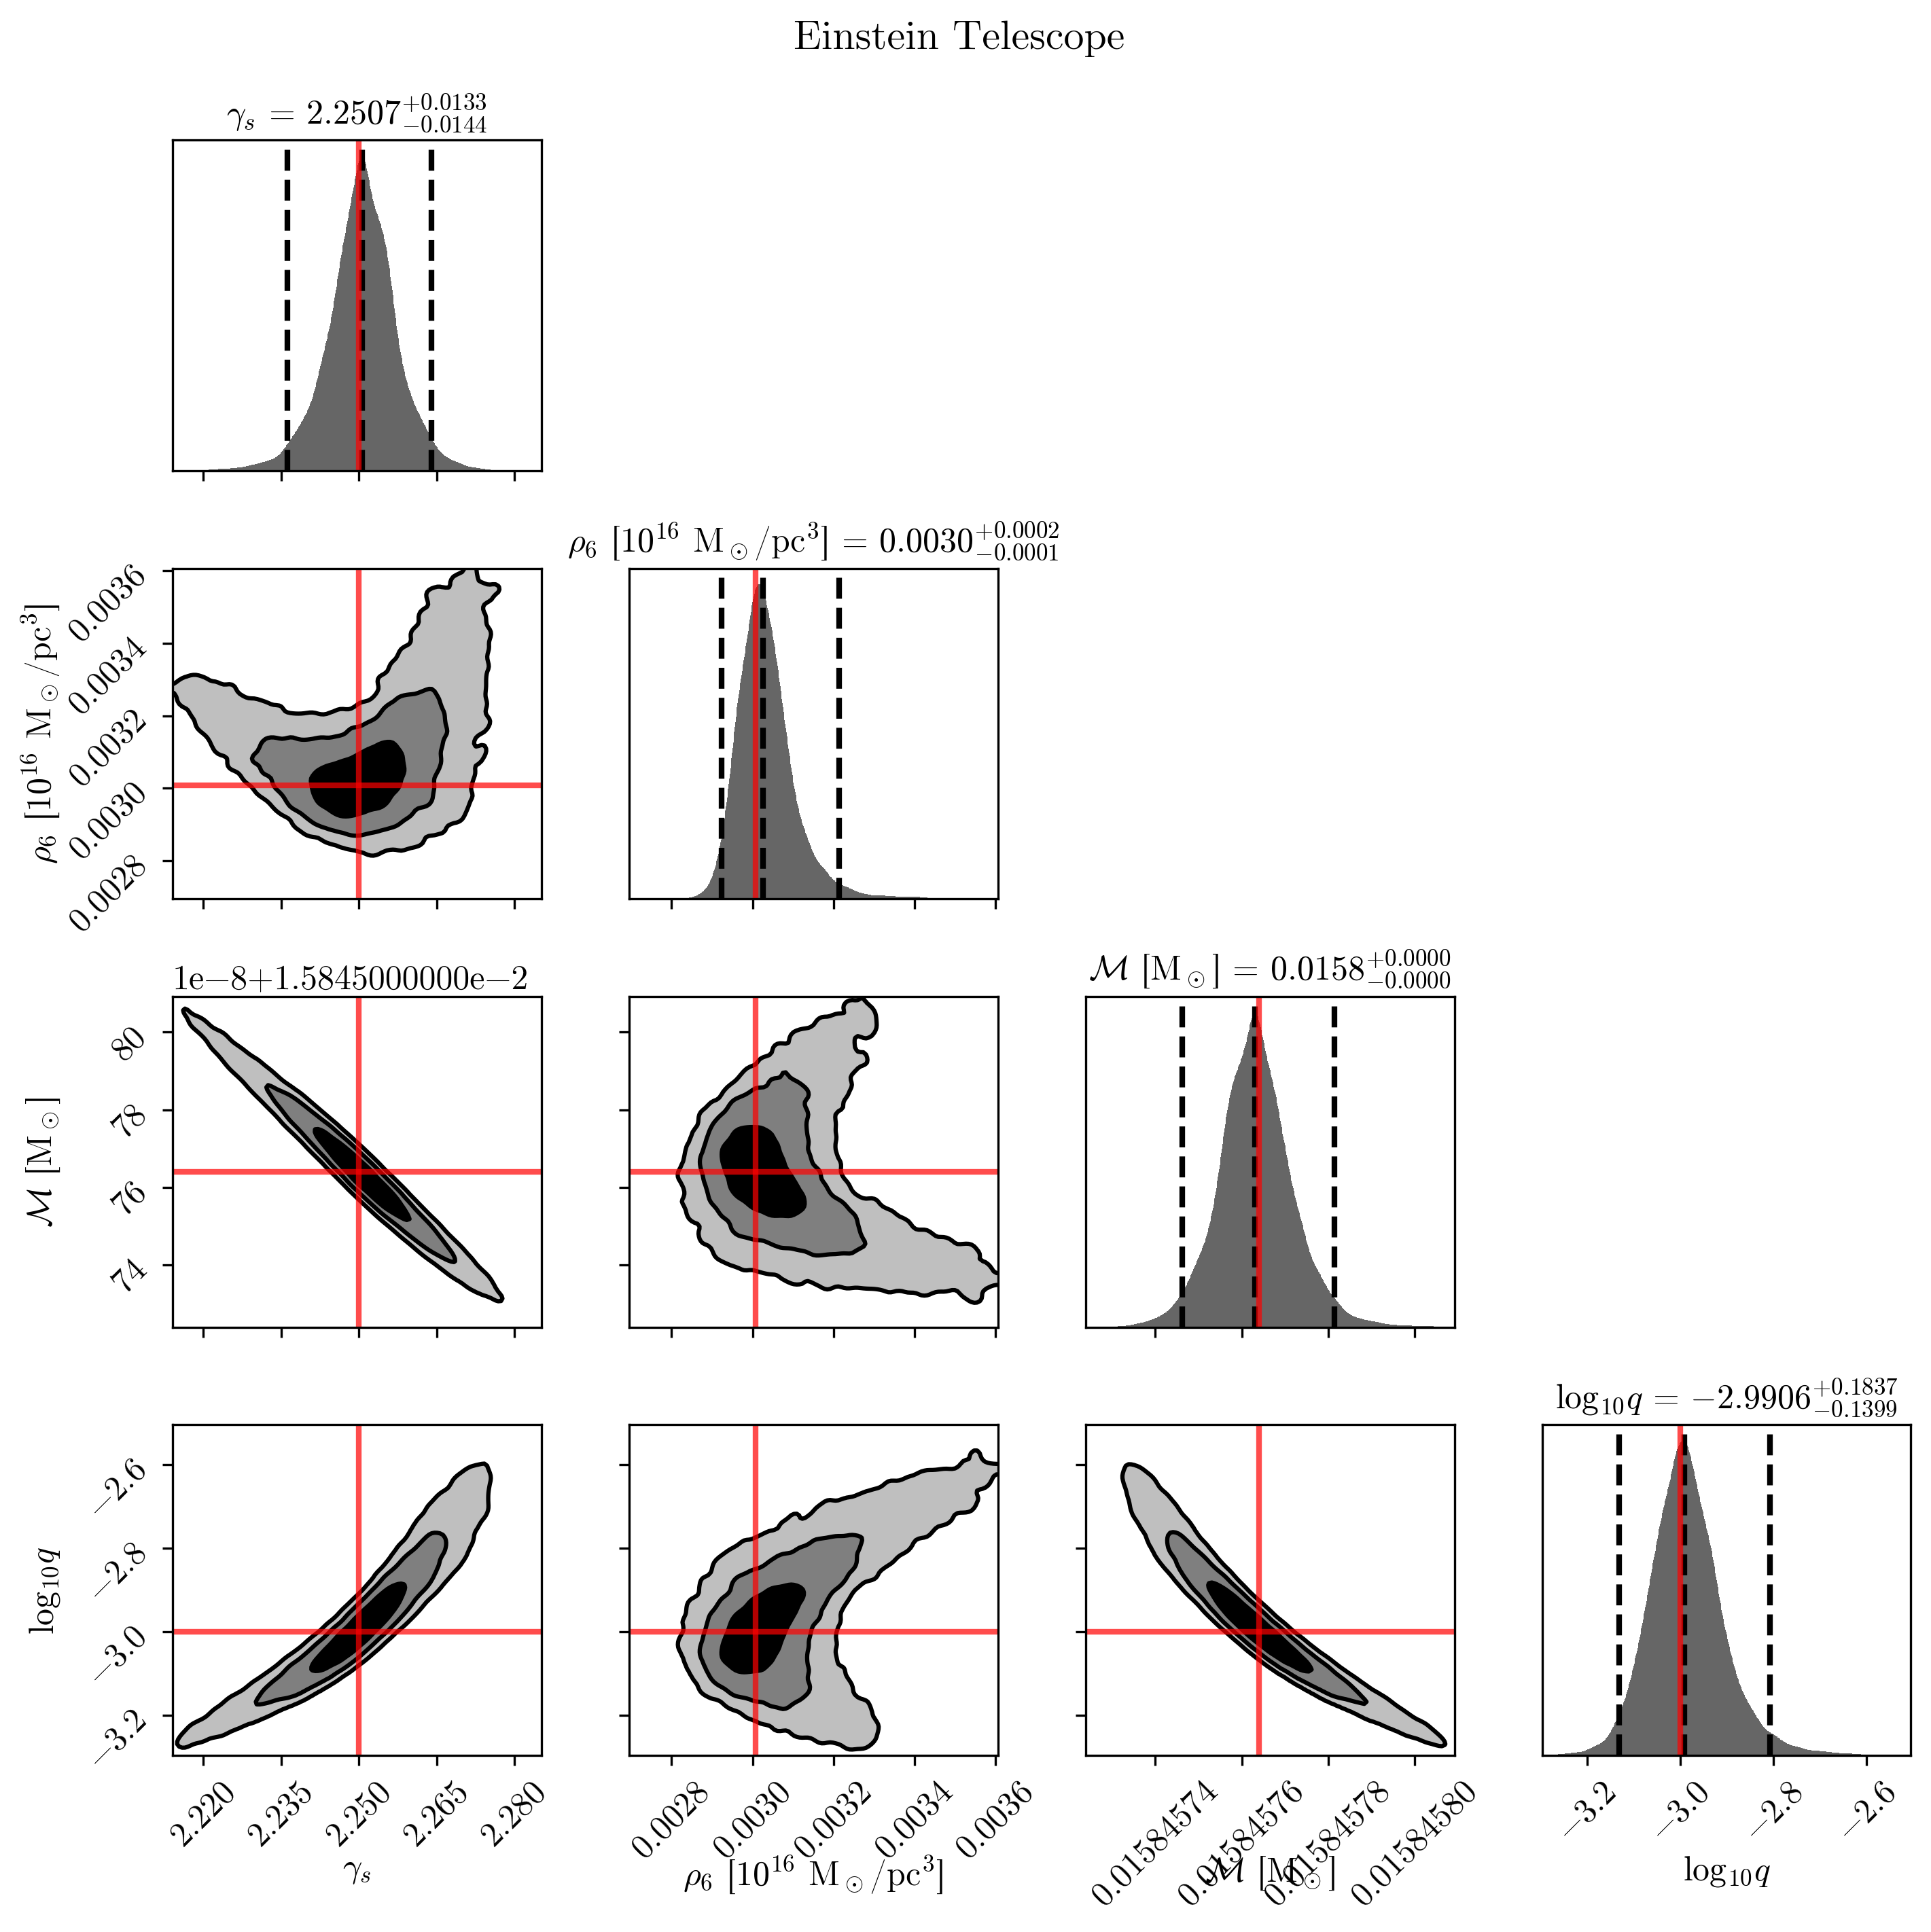

In [140]:
with open(f"ns/ns-et-4d.pkl", "rb") as infile:
    results = pickle.load(infile)

fig, axes = dyplot.cornerplot(
    results,
    labels=labels,
    quantiles_2d=quantiles_2d,
    smooth=0.015,
    truths=truths,
    show_titles=True,
    title_kwargs={"fontsize": 12},
    title_fmt=".4f",
)
fig.suptitle("Einstein Telescope")
fig.tight_layout()
fig.savefig(f"figures/ns-et.pdf")

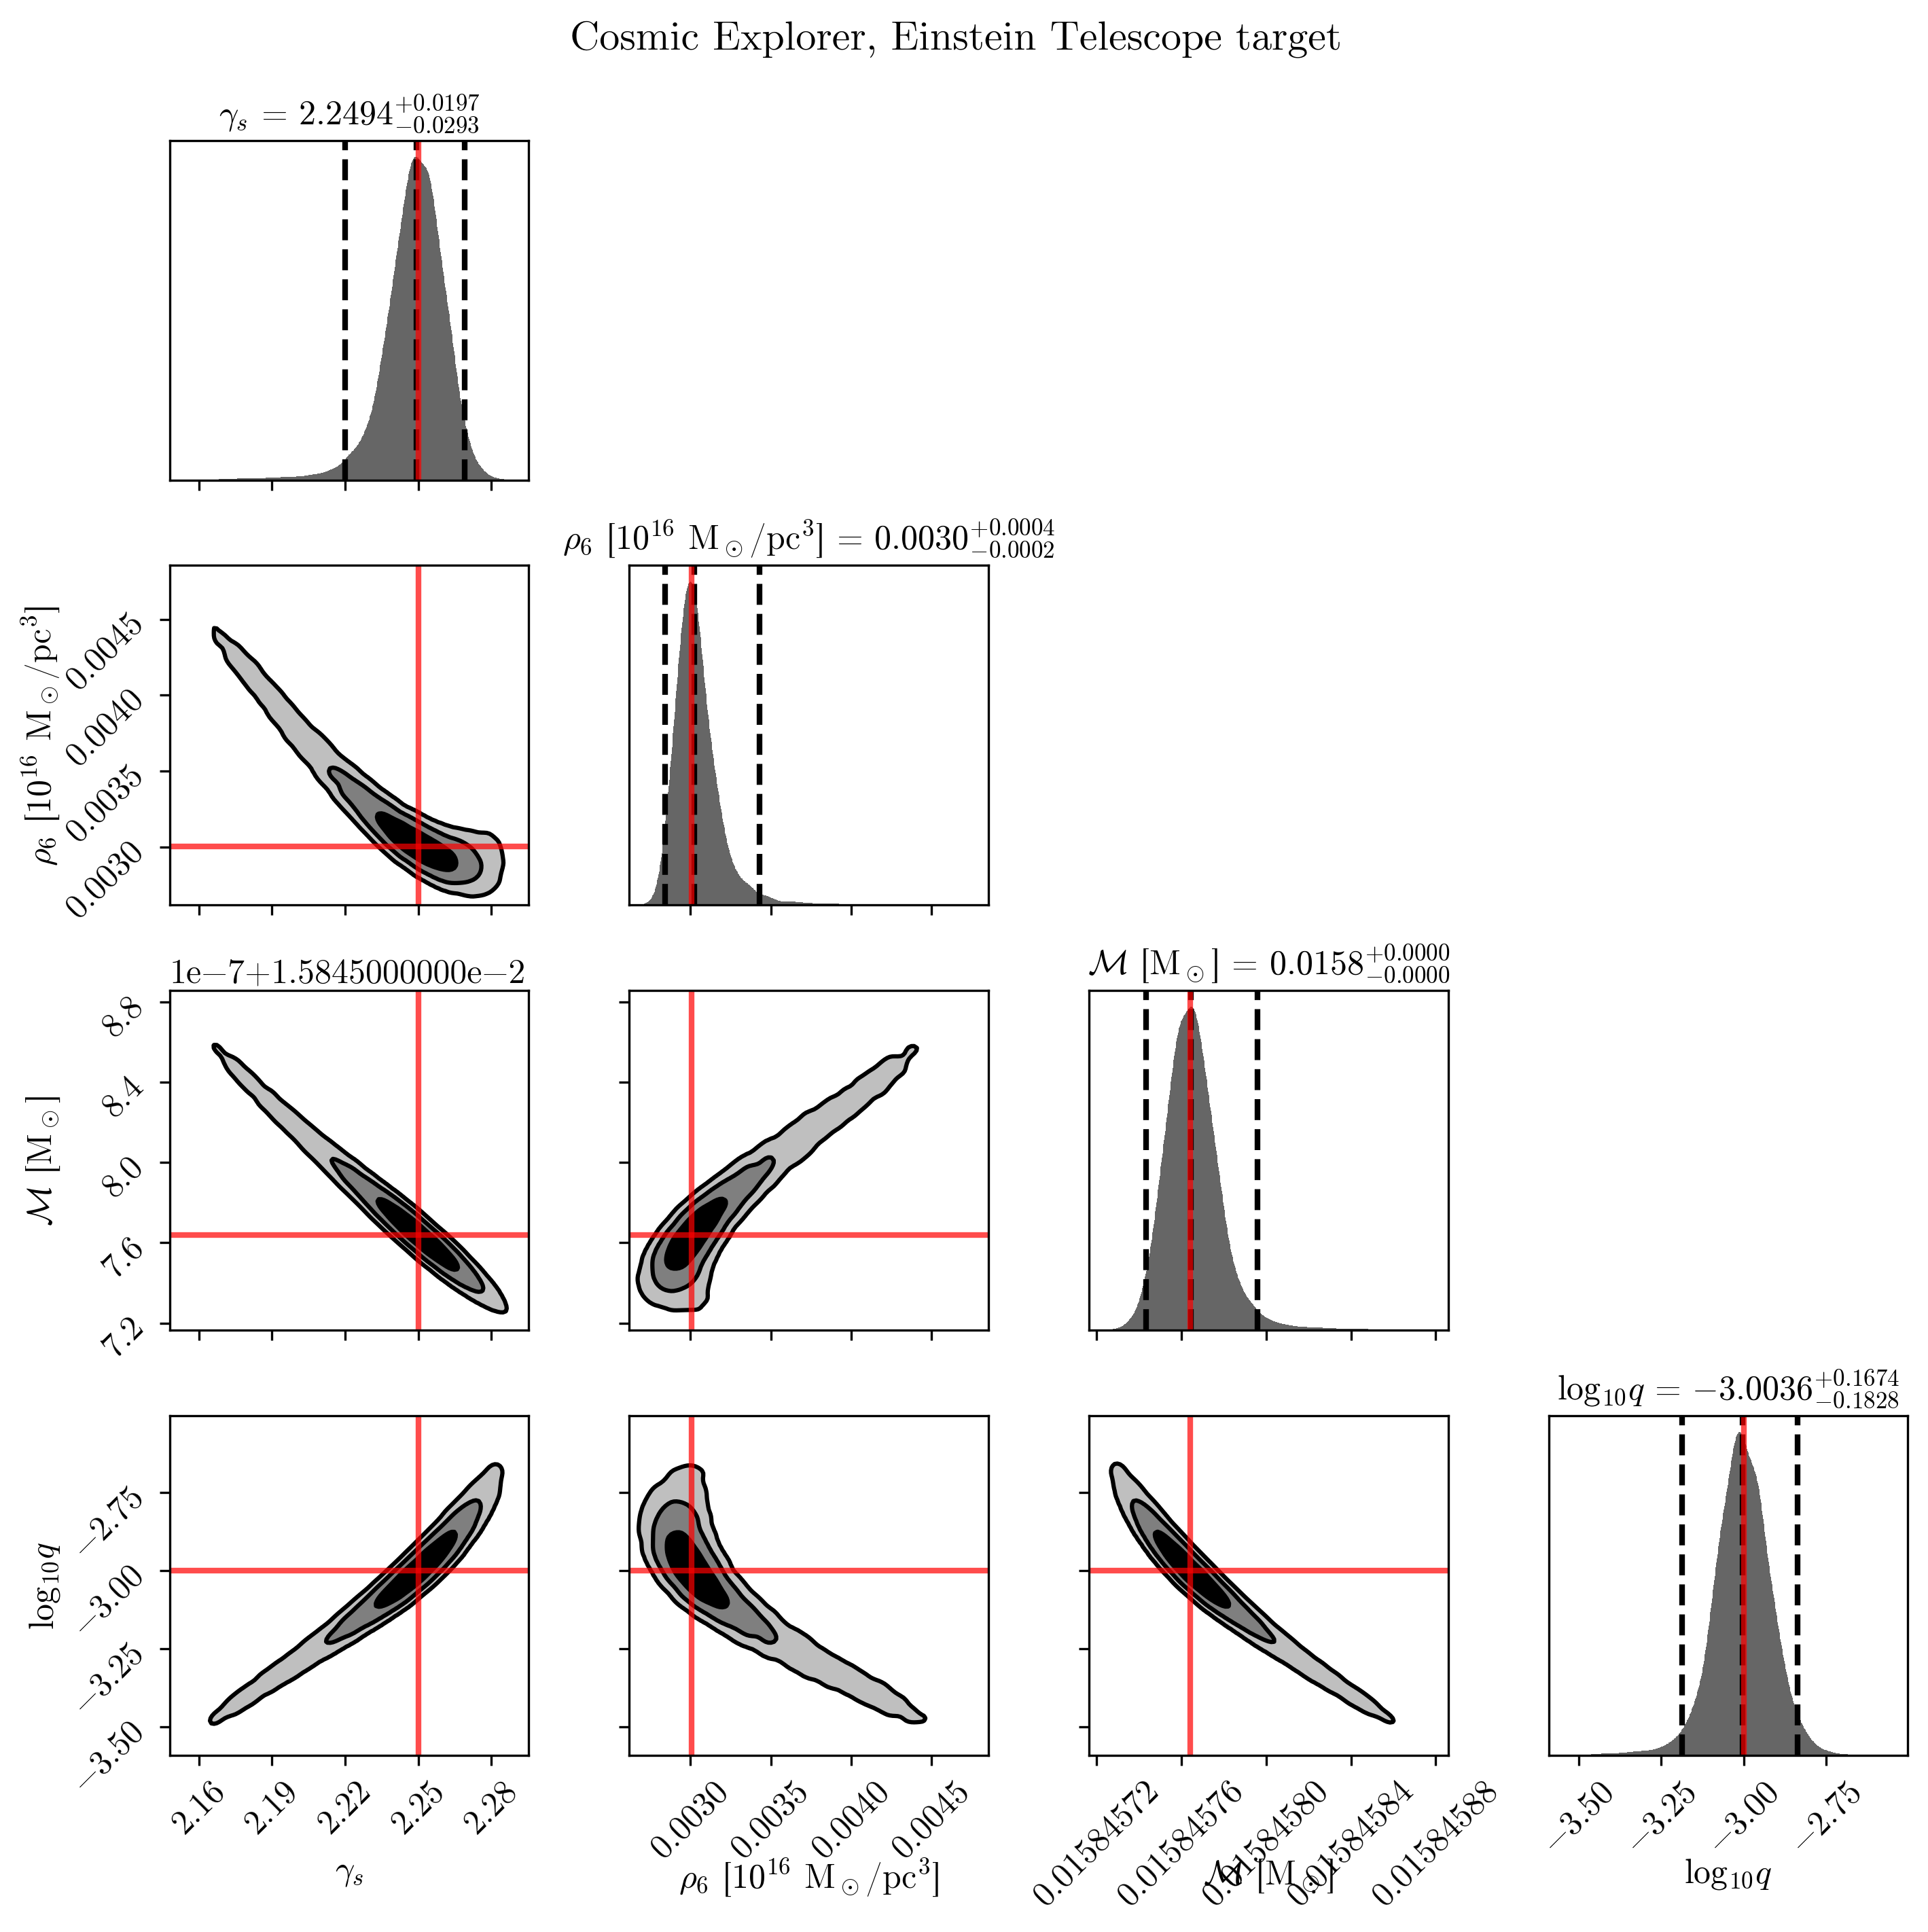

In [141]:
with open(f"ns/ns-ce-et-target-4d.pkl", "rb") as infile:
    results = pickle.load(infile)

fig, axes = dyplot.cornerplot(
    results,
    labels=labels,
    quantiles_2d=quantiles_2d,
    smooth=0.015,
    truths=truths,
    show_titles=True,
    title_kwargs={"fontsize": 12},
    title_fmt=".4f",
)
fig.suptitle("Cosmic Explorer, Einstein Telescope target")
fig.tight_layout()
fig.savefig(f"figures/ns-ce-et-target.pdf")

In [142]:
with open(f"ns/ns-et-4d.pkl", "rb") as infile:
    results_et = pickle.load(infile)

with open(f"ns/ns-ce-et-target-4d.pkl", "rb") as infile:
    results_ce_et_target = pickle.load(infile)

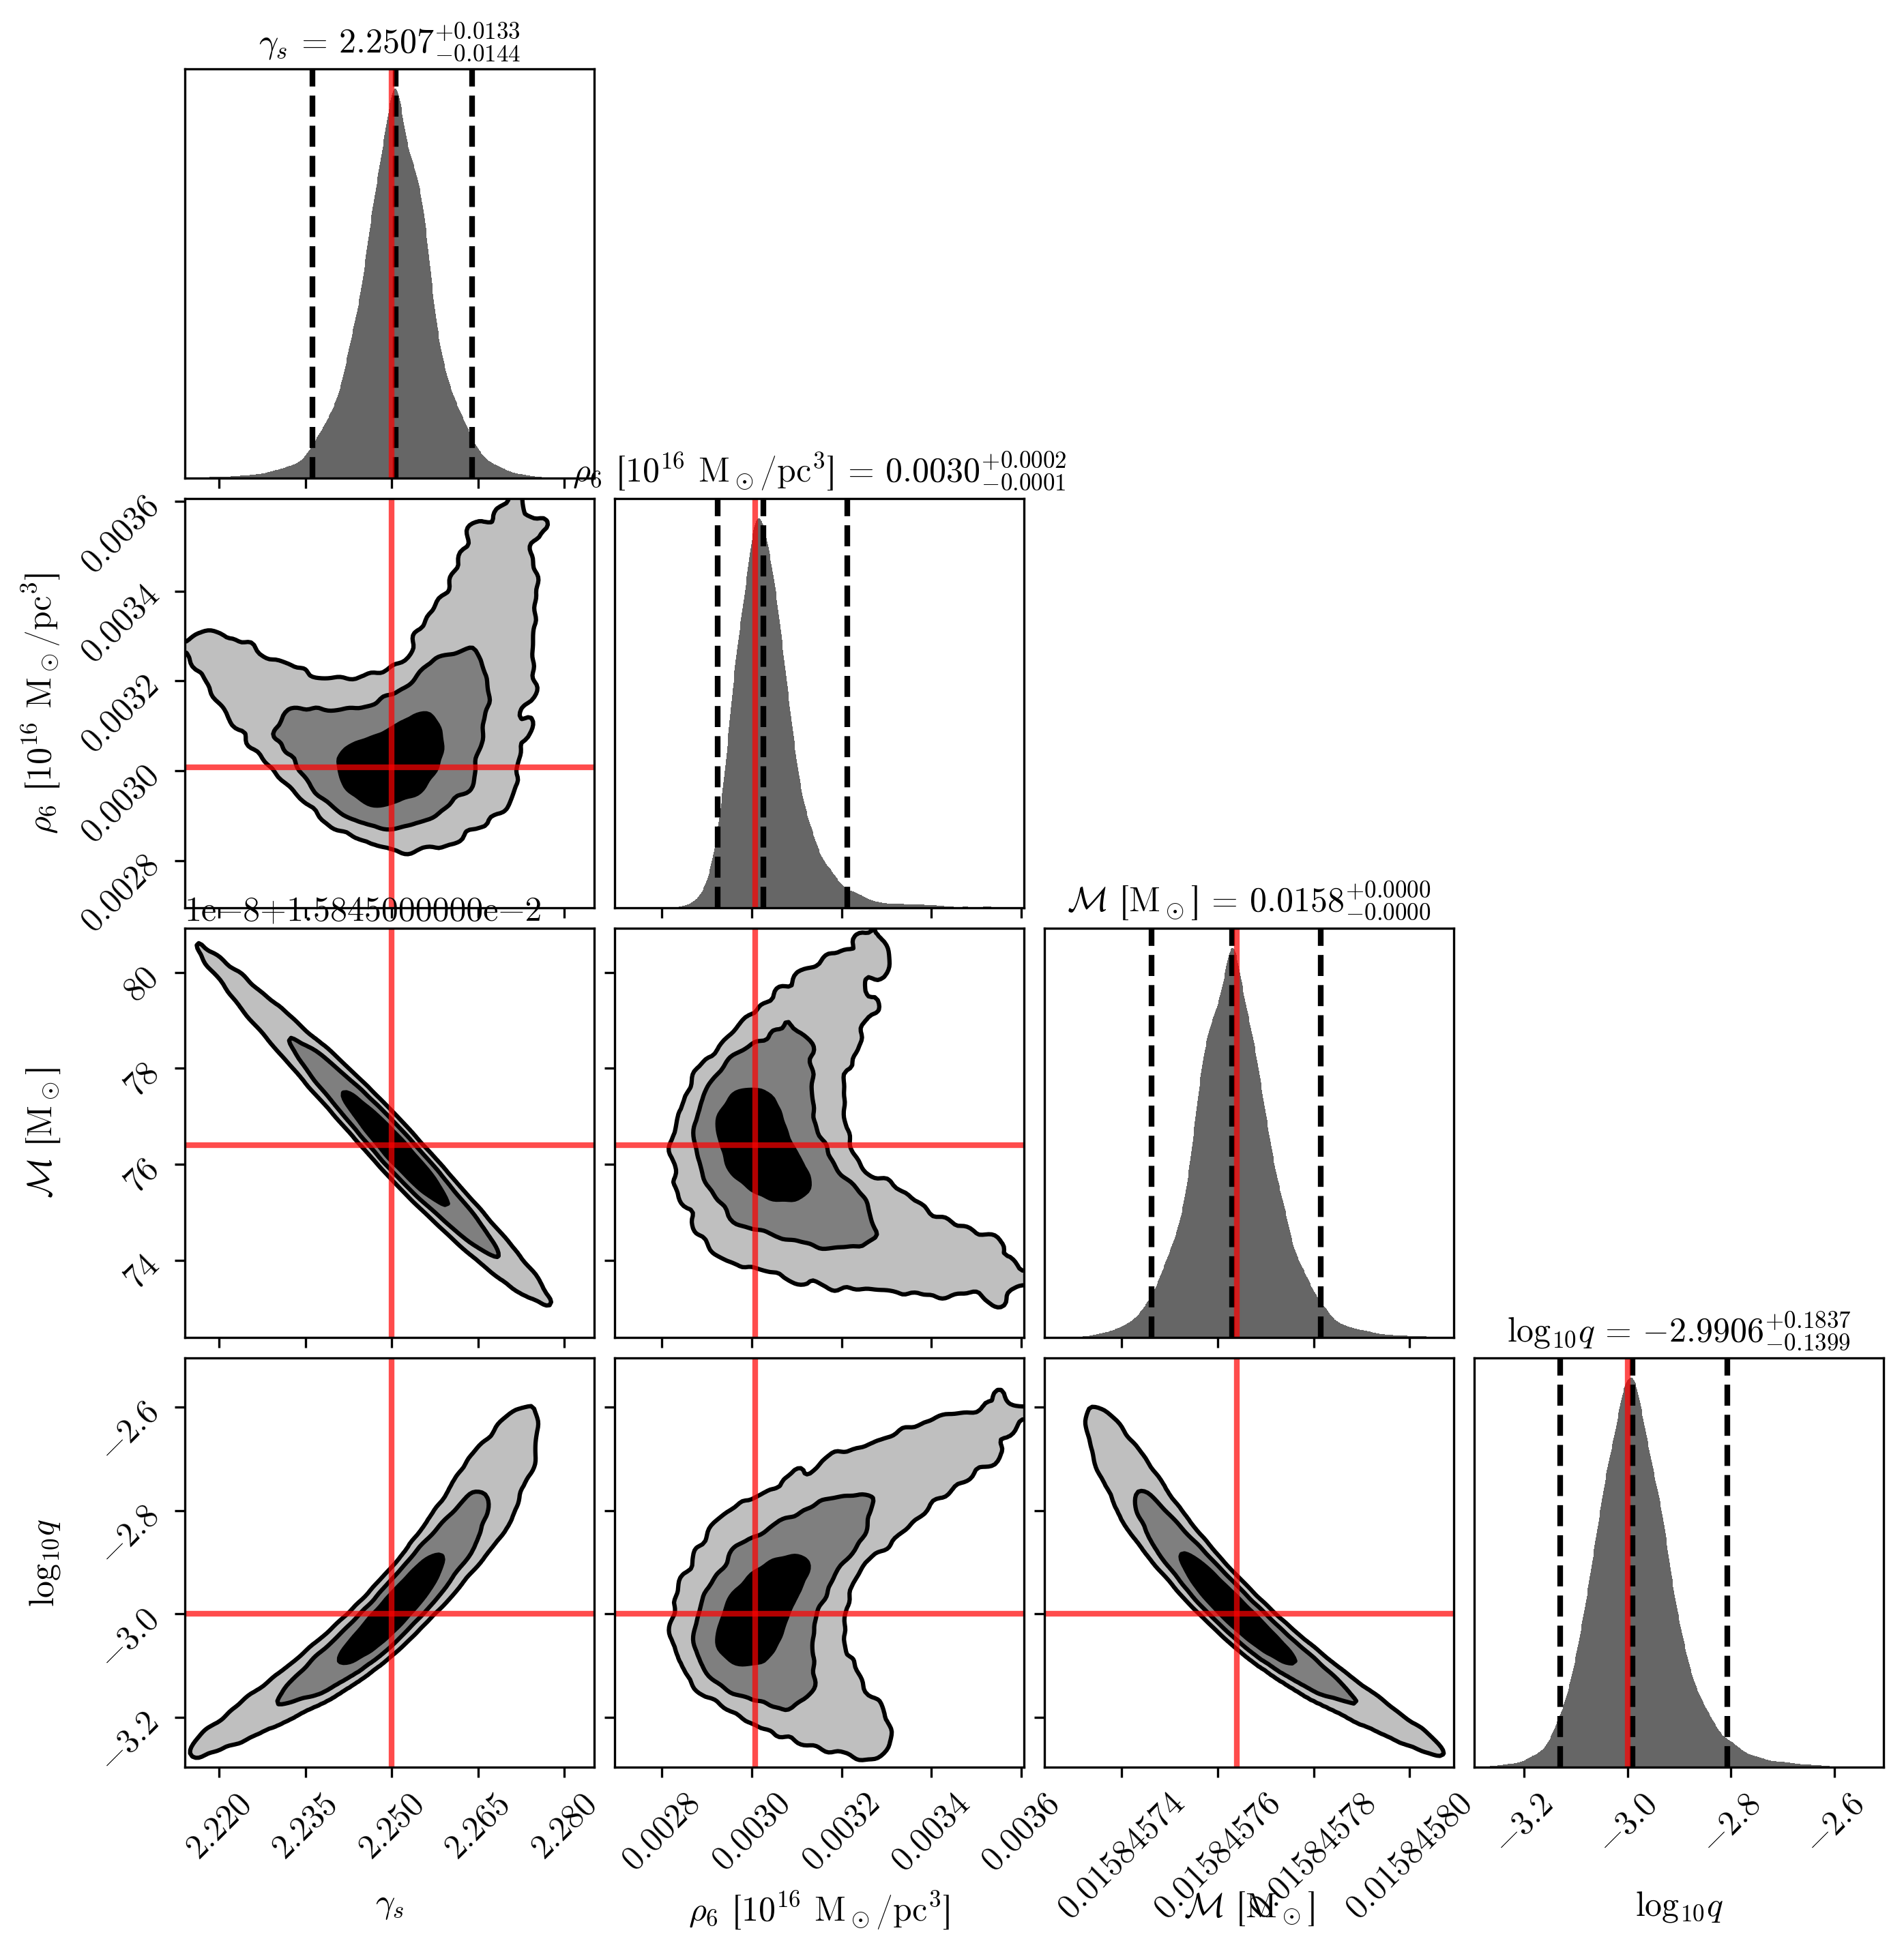

In [143]:
fig, axes = dyplot.cornerplot(
    results_et,
    labels=labels,
    quantiles_2d=quantiles_2d,
    smooth=0.015,
    truths=truths,
    show_titles=True,
    title_kwargs={"fontsize": 12},
    title_fmt=".4f",
)

In [144]:
results["samples"].shape

(46596, 4)

In [ ]:
plt.hist2d

In [199]:
from scipy.ndimage import gaussian_filter as norm_kde


def get_HDI_thresholds(x, cred_level=[0.68268, 0.95450, 0.99730]):
    """
    Taken from swyft.plot.plot
    """
    x = x.flatten()
    x = np.sort(x)[::-1]  # Sort backwards
    total_mass = x.sum()
    enclosed_mass = np.cumsum(x)
    idx = [np.argmax(enclosed_mass >= total_mass * f) for f in cred_level]
    levels = np.array(x[idx])
    return levels


def my_corner(results, axes, color, bins_1d=50, bins_2d=40, smooth=0.015):
    span = [0.999999426697 for i in range(2)]

    samples = results["samples"].T
    ndim = samples.shape[0]
    weights = np.exp(results["logwt"] - results["logz"][-1])

    for i, x in enumerate(samples):
        ax = axes[i, i]
        ax.hist(x, weights=weights, bins=bins_1d, histtype="step", color=color)

        for j, y in enumerate(samples):
            ax = axes[i, j]
            if j == i:
                continue
            if j > i:
                ax.axis("off")
                continue
            counts, xbins, ybins = np.histogram2d(y, x, weights=weights, bins=bins_2d)
            levels = sorted(get_HDI_thresholds(counts))
            ax.contour(
                counts.T,
                extent=[xbins.min(), xbins.max(), ybins.min(), ybins.max()],
                levels=levels,
                colors=[color],
            )

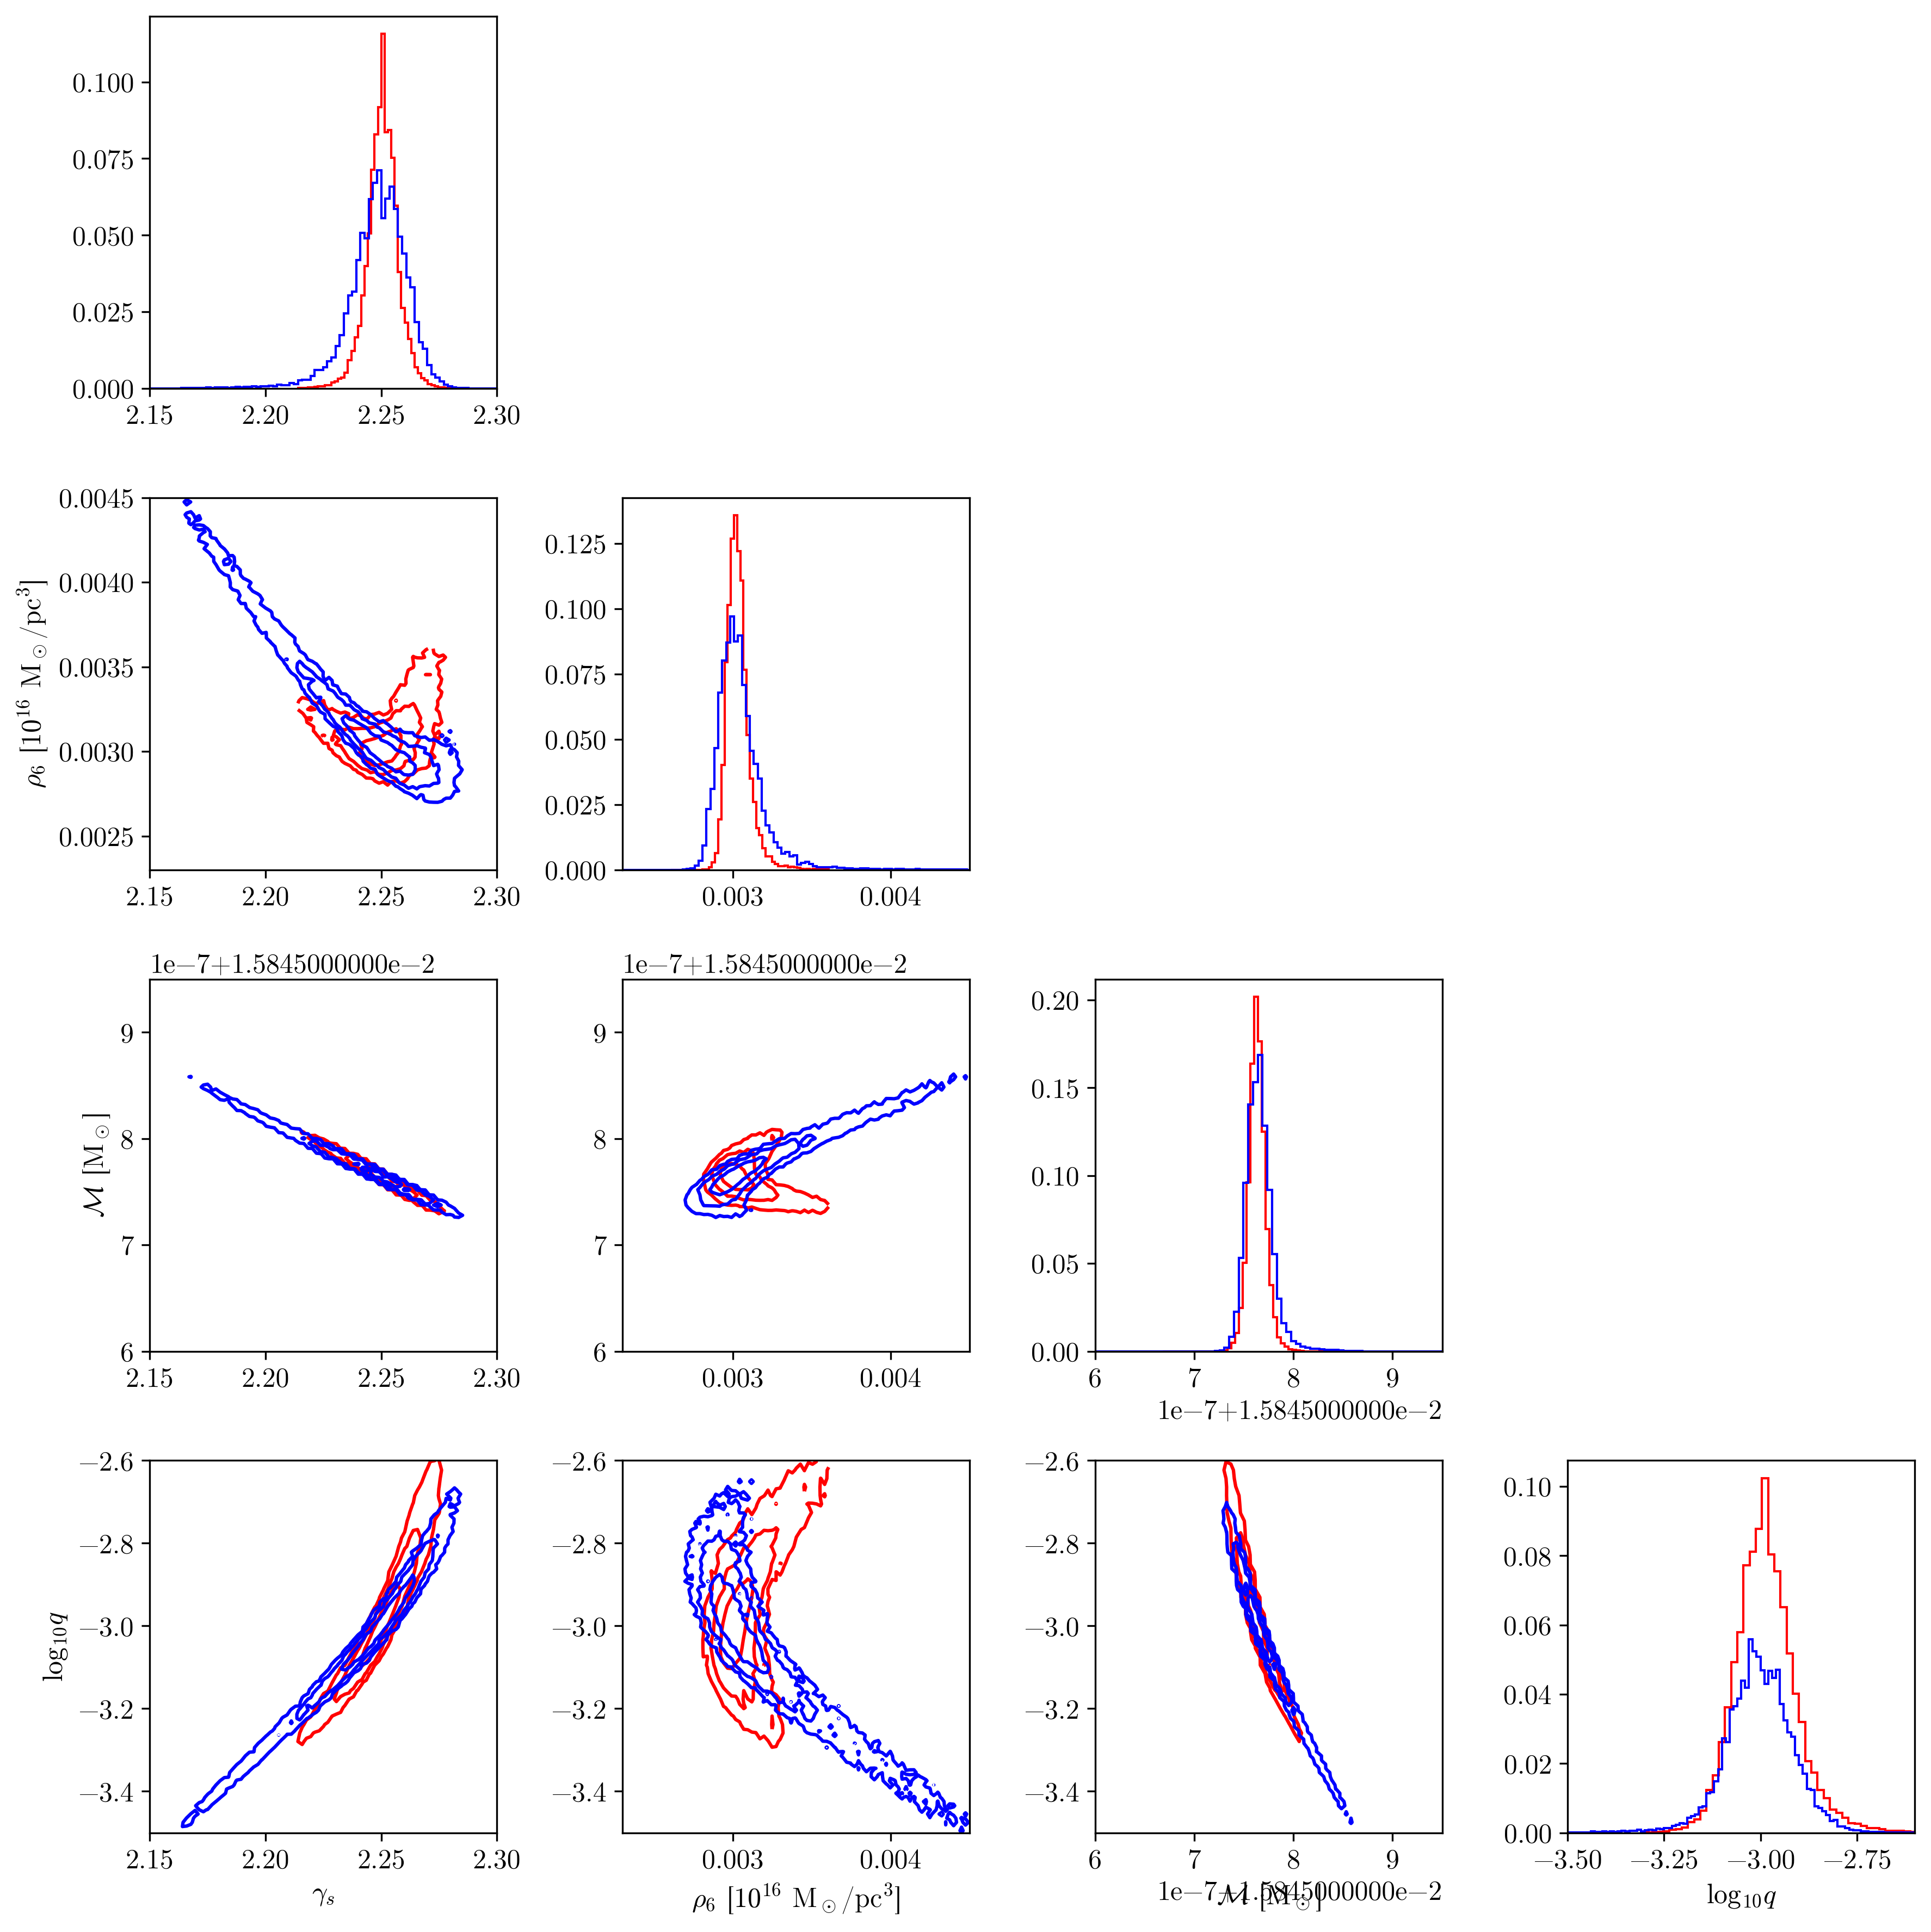

In [213]:
ndim = 4
fig, axes = plt.subplots(ndim, ndim, figsize=(3 * ndim, 3 * ndim))

my_corner(results_et, axes, "r")
my_corner(results_ce_et_target, axes, "b", 200, 200)

for i, ax in enumerate(axes[-1, :]):
    ax.set_xlabel(labels[i])

for j, ax in enumerate(axes[1:, 0], 1):
    ax.set_ylabel(labels[j])

ranges = [
    (2.15, 2.3),
    (0.0023, 0.0045),
    (1.5845e-2 + 6e-7, 1.5845e-2 + 9.5e-7),
    (-3.5, -2.6),
]
for i in range(ndim):
    for j in range(i, ndim):
        axes[j, i].set_xlim(ranges[i])

for i in range(1, ndim):
    for j in range(0, i):
        axes[i, j].set_ylim(ranges[i])

fig.tight_layout()